# Training machine learning models on tabular data: an end-to-end example (Unity Catalog)

This tutorial shows you how to train and register Models in Unity Catalog. Databricks includes a hosted MLflow Model Registry in Unity Catalog, compatible with the open-source MLflow Python client. Benefits include centralized access control, auditing, lineage, and model discovery across workspaces. For details about managing the model lifecycle with Unity Catalog, see (AWS | Azure | GCP).

This tutorial covers the following steps:

Visualize the data using Seaborn and matplotlib
Run a parallel hyperparameter sweep to train multiple models
Explore hyperparameter sweep results with MLflow
Register the best performing model in MLflow
Apply the registered model to another dataset using a Spark UDF
In this example, you build a model to predict the quality of Portuguese "Vinho Verde" wine based on the wine's physicochemical properties.

The example uses a dataset from the UCI Machine Learning Repository, presented in Modeling wine preferences by data mining from physicochemical properties [Cortez et al., 2009].


### NOTE
```
# Step 1: install: 
https://github.com/triton-inference-server/server/tree/main/deploy/mlflow-triton-plugin
- python setup.py build
- python setup.py install

# step 2 Start Triton Inference Server in EXPLICIT mode

+ if we cache model at local server to run, plz edit the follow command and run it:

docker run --gpus all -p 8000:8000 -p 8001:8001 -p 8002:8002 -v <local path>:/models --name tritonserver nvcr.io/nvidia/tritonserver:24.07-py3 tritonserver --model-repository=/models --model-control-mode=explicit --log-verbose=3

+ if we cache model at S3 to run, plz edit the follow command and run it:

docker run --gpus all -p 8000:8000 -p 8001:8001 -p 8002:8002 -e AWS_ACCESS_KEY_ID=<KEY ***> -e AWS_SECRET_ACCESS_KEY=<KEY ***> -e AWS_DEFAULT_REGION=us-east-1 --name tritonserver nvcr.io/nvidia/tritonserver:24.07-py3 tritonserver --model-repository=<ENV OF TRITON_MODEL_REPO > --model-control-mode=explicit --log-verbose=3


```

In [1]:
from math import exp
import mlflow.xgboost
import numpy as np
import xgboost as xgb

import mlflow.pyfunc
import mlflow.sklearn
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from mlflow.models.signature import infer_signature
from mlflow.utils.environment import _mlflow_conda_env
import cloudpickle
import time

from mlflow.tracking import MlflowClient
import mlflow


In [2]:
import os
os.environ['MLFLOW_TRACKING_USERNAME'] = "cuong"
os.environ['MLFLOW_TRACKING_PASSWORD'] = "ds@cuong1"

In [3]:
remote_server_uri = "http://localhost:5005"  # set to your server URI
mlflow.set_tracking_uri(remote_server_uri)
mlflow.set_experiment("experiment winequality triton")
CATALOG_NAME = "main"
SCHEMA_NAME = "triton"

# Read the data
Read the white wine quality and red wine quality CSV datasets and merge them into a single DataFrame.

In [4]:
# trick
# You can copy/paste the url and change 2 things:

# Remove "blob"
# Replace github.com by raw.githubusercontent.com
# For instance this link:

import pandas as pd 
red_wine = pd.read_table("https://raw.githubusercontent.com//aniruddhachoudhury/Red-Wine-Quality/master/winequality-red.csv", sep=",")
white_wine = pd.read_table("https://raw.githubusercontent.com//stedy/Machine-Learning-with-R-datasets/master/winequality-white.csv", sep=",")


In [5]:
red_wine.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [6]:
white_wine.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [7]:
red_wine['is_red'] = 1
white_wine['is_red'] = 0

data = pd.concat([red_wine, white_wine], axis=0)

# Remove spaces from column names
data.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)

# Visualize data
Before training a model, explore the dataset using Seaborn and Matplotlib.

Plot a histogram of the dependent variable, quality.

In [8]:
# pip install --upgrade seaborn

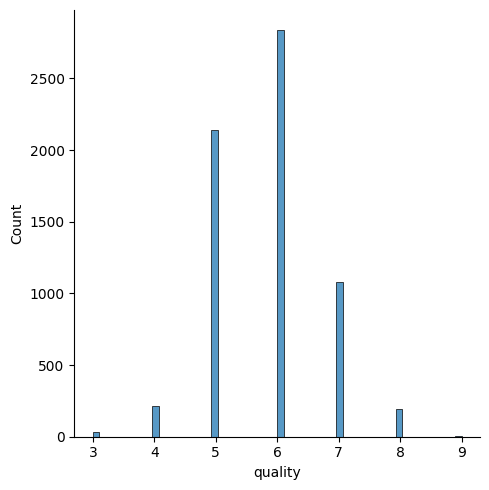

In [9]:
import seaborn as sns
sns.displot(data.quality, kde=False)

Looks like quality scores are normally distributed between 3 and 9.

Define a wine as high quality if it has quality >= 7.

In [10]:
high_quality = (data.quality >= 7).astype(int)
data.quality = high_quality

Box plots are useful for identifying correlations between features and a binary label. Create box plots for each feature to compare high-quality and low-quality wines. Significant differences in the box plots indicate good predictors of quality.

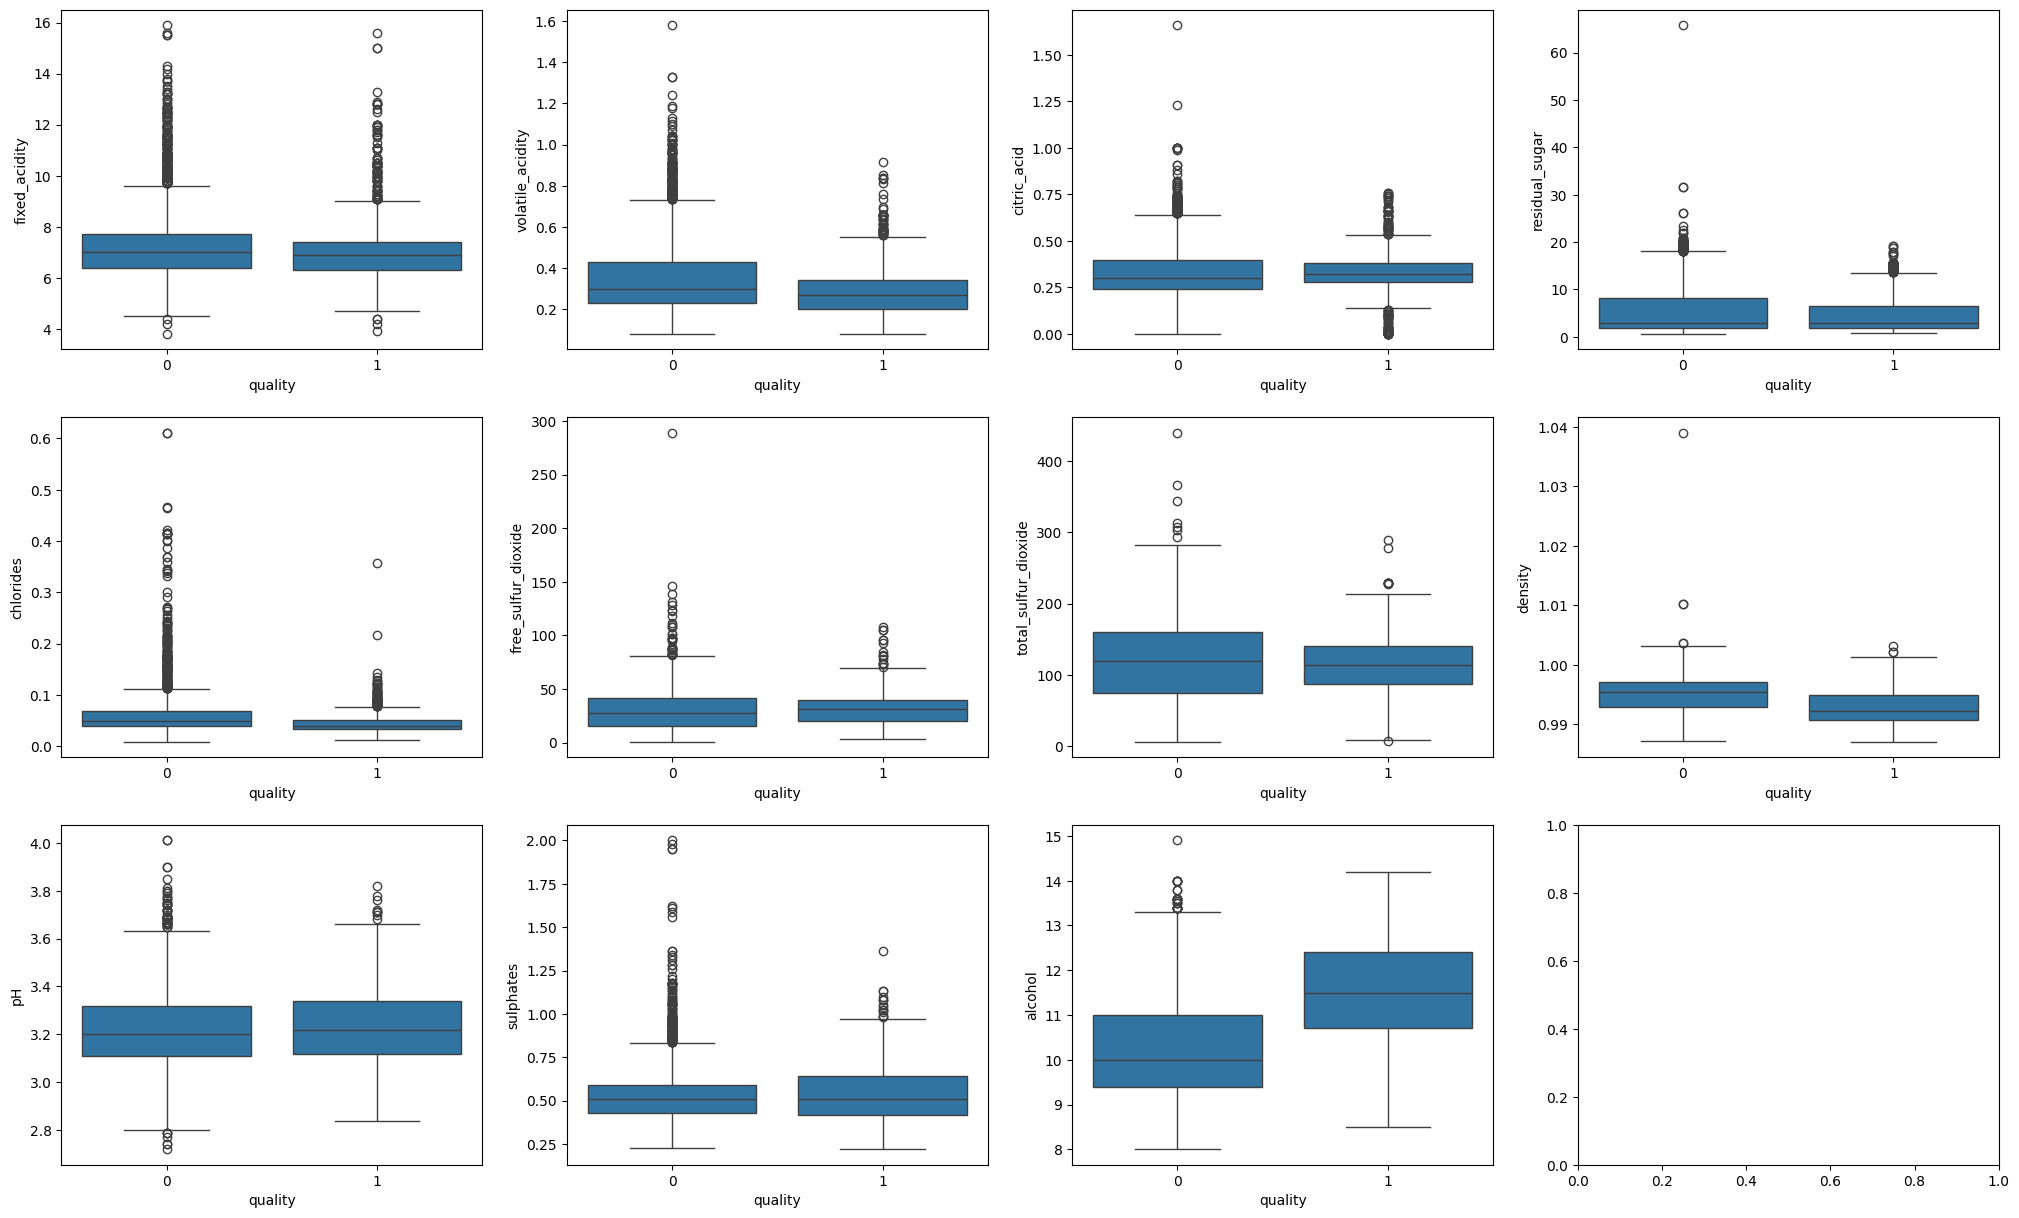

In [11]:
import matplotlib.pyplot as plt

dims = (3, 4)

f, axes = plt.subplots(dims[0], dims[1], figsize=(25, 15))
axis_i, axis_j = 0, 0
for col in data.columns:
  if col == 'is_red' or col == 'quality':
    continue # Box plots cannot be used on indicator variables
  sns.boxplot(x=high_quality, y=data[col], ax=axes[axis_i, axis_j])
  axis_j += 1
  if axis_j == dims[1]:
    axis_i += 1
    axis_j = 0

In the above box plots, a few variables stand out as good univariate predictors of quality.

In the alcohol box plot, the median alcohol content of high quality wines is greater than even the 75th quantile of low quality wines. High alcohol content is correlated with quality.
In the density box plot, low quality wines have a greater density than high quality wines. Density is inversely correlated with quality.

# Preprocess data
Before training a model, check for missing values and split the data into training and validation sets.

In [12]:
data.isna().any()

fixed_acidity           False
volatile_acidity        False
citric_acid             False
residual_sugar          False
chlorides               False
free_sulfur_dioxide     False
total_sulfur_dioxide    False
density                 False
pH                      False
sulphates               False
alcohol                 False
quality                 False
is_red                  False
dtype: bool

There are no missing values.

# Prepare the dataset to train a baseline model
Split the input data into 3 sets:

Train (60% of the dataset used to train the model)
Validation (20% of the dataset used to tune the hyperparameters)
Test (20% of the dataset used to report the true performance of the model on an unseen dataset)

In [13]:
from sklearn.model_selection import train_test_split

X = data.drop(["quality"], axis=1)
y = data.quality

# Split out the training data
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.6, random_state=123)

# Split the remaining data equally into validation and test
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=123)

# Train a baseline model
This task seems well suited to a random forest classifier, since the output is binary and there may be interactions between multiple variables.

Build a simple classifier using scikit-learn and use MLflow to keep track of the model's accuracy and save the model for later use.

In [14]:
import os
os.environ['MLFLOW_S3_ENDPOINT_URL'] = "http://172.19.164.128:9000"
os.environ['MLFLOW_ARTIFACT_URI'] = "s3://mlflow-artifacts/mlflow"
os.environ['AWS_ACCESS_KEY_ID'] = "zL8jRR2H28UZ6k2ZSTGe"
os.environ['AWS_SECRET_ACCESS_KEY'] = "0g23JxsUWV9LovRCuXZbazkMwXgXpEd7kPuKbCxc" 

In [43]:
def gen_onnx_from_model(model, model_name, model_version, num_features, model_repo, json_input, json_expected_output,
                        use_gpu=True, max_batch_size=1000, instance_kind='KIND_GPU'):
    if use_gpu:
        from skl2onnx import convert_sklearn
        from skl2onnx.common.data_types import FloatTensorType
        onnx_name = model_name
        onnx_version= model_version
        onnx_dir = os.path.join(model_repo, onnx_name)
        onnx_versioned_dir = os.path.join(onnx_dir, onnx_version)
    
        os.makedirs(onnx_versioned_dir, exist_ok=True)
    
        onnx_path = os.path.join(onnx_versioned_dir, 'model.onnx')

        onnx_model = convert_sklearn(
            model,
            initial_types=[('input', FloatTensorType([None, num_features]))],
            target_opset=12,
            options={'zipmap': False}
        )
        
        outputs = {output.name: output for output in onnx_model.graph.output}
        onnx_model.graph.output.remove(outputs['label'])
        with open(onnx_path, 'wb') as file_:
            file_.write(onnx_model.SerializeToString())
    
        config_text = f"""platform: "onnxruntime_onnx",
max_batch_size: {max_batch_size}
input [                                 
 {{  
    name: "input"
    data_type: TYPE_FP32
    dims: [ {num_features} ]                    
  }} 
]
output [
 {{
    name: "probabilities"
    data_type: TYPE_FP32
    dims: [ 2 ]
  }}
]
instance_group [{{ kind: {instance_kind} }}]
parameters [
  {{
    key: "intra_op_thread_count"
    value: {{ string_value: "8" }}
  }},
  {{
    key: "cudnn_conv_algo_search"
    value: {{ string_value: "1" }}
  }}
]

dynamic_batching {{}}"""
    
        config_path = os.path.join(onnx_dir, 'config.pbtxt')
        with open(config_path, 'w') as file_:
            file_.write(config_text)
        # import json
        # with open(f"{onnx_dir}/input.json", "w") as write_file:
        #     json.dump(json_input, write_file, indent=4)
        # with open(f"{onnx_dir}/expected_output.json", "w") as write_file:
        #     json.dump(json_expected_output, write_file, indent=4)
            
    return onnx_path, onnx_dir

In [32]:
"""
The ``triton`` module provides APIs for logging and loading Triton-recognized
models in the MLflow Model format. This module exports MLflow Models with the following
flavors:

Triton format
    model files in the structure that Triton can load the model from.

"""
import os
import shutil
import sys

from mlflow.exceptions import MlflowException
from mlflow.models import Model
from mlflow.models.model import MLMODEL_FILE_NAME
from mlflow.protos.databricks_pb2 import RESOURCE_ALREADY_EXISTS
from mlflow.tracking._model_registry import DEFAULT_AWAIT_MAX_SLEEP_SECONDS
from mlflow.utils.annotations import experimental

FLAVOR_NAME = "triton"


@experimental
def save_model(
    triton_model_path,
    path,
    mlflow_model=None,
):
    """
    Save an Triton model to a path on the local file system.

    :param triton_model_path: File path to Triton model to be saved.
    :param path: Local path where the model is to be saved.
    :param mlflow_model: :py:mod:`mlflow.models.Model` this flavor is being added to.

    """

    path = os.path.abspath(path)
    if os.path.exists(path):
        raise MlflowException(
            message="Path '{}' already exists".format(path),
            error_code=RESOURCE_ALREADY_EXISTS,
        )
    os.makedirs(path)
    triton_model_path = os.path.normpath(triton_model_path)
    model_data_subpath = os.path.basename(triton_model_path)
    model_data_path = os.path.join(path, model_data_subpath)

    # Save Triton model
    shutil.copytree(triton_model_path, model_data_path)

    mlflow_model.add_flavor(FLAVOR_NAME, data=model_data_subpath)
    mlflow_model.save(os.path.join(path, MLMODEL_FILE_NAME))


@experimental
def log_model(
    triton_model_path,
    artifact_path,
    registered_model_name=None,
    await_registration_for=DEFAULT_AWAIT_MAX_SLEEP_SECONDS,
):
    """
    Log an Triton model as an MLflow artifact for the current run.

    :param triton_model_path: File path to Triton model.
    :param artifact_path: Run-relative artifact path.
    :param registered_model_name: (Experimental) If given, create a model version under
                                  ``registered_model_name``, also creating a registered model if one
                                  with the given name does not exist.

    :param await_registration_for: Number of seconds to wait for the model version to finish
                            being created and is in ``READY`` status. By default, the function
                            waits for five minutes. Specify 0 or None to skip waiting.

    """
    Model.log(
        artifact_path=artifact_path,
        flavor=sys.modules[__name__],
        triton_model_path=triton_model_path,
        registered_model_name=registered_model_name,
        await_registration_for=await_registration_for,
    )

In [33]:
columns = X_train.columns

In [45]:
# mlflow.start_run creates a new MLflow run to track the performance of this model. 
# Within the context, you call mlflow.log_param to keep track of the parameters used, and
# mlflow.log_metric to record metrics like accuracy.
with mlflow.start_run(run_name='untuned_random_forest'):
    n_estimators = 10
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=np.random.RandomState(123))
    model.fit(X_train, y_train)

    # predict_proba returns [prob_negative, prob_positive], so slice the output with [:, 1]
    predictions_test = model.predict_proba(X_test)[:,1]
    auc_score = roc_auc_score(y_test, predictions_test)
    mlflow.log_param('n_estimators', n_estimators)
    # Use the area under the ROC curve as a metric.
    mlflow.log_metric('auc', auc_score)

    artifact_path = "model"

    mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path=artifact_path,
        input_example=X_train.iloc[[0]],
        pyfunc_predict_fn="predict_proba",
        metadata={"model_data_version": 1},
    )

    # Get the logged model uri so that we can load it from the artifact store
    model_uri = mlflow.get_artifact_uri(artifact_path)
    
    # Log the model with a signature that defines the schema of the model's inputs and outputs. 
    # When the model is deployed, this signature will be used to validate inputs.
    json_input = {"inputs": {f"INPUT{i}":[X_train.iloc[:10, i].to_list()]  for i , v in enumerate(range(len(columns)))} }
    json_expected_output = {"outputs": {f"OUTPUT0": [list(predictions_test[:10])]  } }
    onnx_path, onnx_dir = gen_onnx_from_model(model, 
                    model_name="randomforest_model", model_version="2",
                    num_features=len(X_train.columns), 
                    model_repo="data/model_repository",
                    json_input=json_input,
                    json_expected_output=json_expected_output,
                    use_gpu=True,
                    max_batch_size=1000, 
                    instance_kind='KIND_GPU')
    shutil.rmtree(onnx_dir, ignore_errors=True)

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. I

In [46]:
feature_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns.tolist(), columns=['importance'])
feature_importances.sort_values('importance', ascending=False)

,importance
alcohol,0.160192
density,0.117415
volatile_acidity,0.093136
chlorides,0.086618
residual_sugar,0.082544
free_sulfur_dioxide,0.080473
pH,0.080212
total_sulfur_dioxide,0.077798
sulphates,0.075780
citric_acid,0.071857


You logged the Area Under the ROC Curve (AUC) to MLflow. Click the Experiment icon  in the right sidebar to display the Experiment Runs sidebar.

The model achieved an AUC of 0.854.

A random classifier would have an AUC of 0.5, and higher AUC values are better. For more information, see Receiver Operating Characteristic Curve.

# Register the model to Unity Catalog
By registering this model to Unity Catalog, you can easily reference the model from anywhere within Databricks.

The following section shows how to do this programmatically, but you can also register a model using the UI.



In [47]:
run_id = mlflow.search_runs(filter_string='tags.mlflow.runName = "untuned_random_forest"').iloc[0].run_id

## step 3 Publish Models to Mlflow server

In [49]:
# publish Model to Mlflow server
log_model(
    onnx_dir,
    "triton",
    registered_model_name="randomforest_model",
)

# Register the model to Unity Catalog. 
model_name = f"{CATALOG_NAME}.{SCHEMA_NAME}.wine_quality"
model_version = mlflow.register_model(f"runs:/{run_id}/randomforest_model", model_name)

# Registering the model takes a few seconds, so add a small delay
time.sleep(15)

Registered model 'main.triton.wine_quality' already exists. Creating a new version of this model...
2024/08/21 13:32:51 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: main.triton.wine_quality, version 4
Created version '4' of model 'main.triton.wine_quality'.


In [62]:
model_name, model_version.version

('randomforest_model', '4')

In [51]:
client = MlflowClient()
client.set_registered_model_alias(model_name, "Champion", model_version.version)

In Unity Catalog, the model version now has the tag "Champion".

You can now refer to the model using the path "models:/{model_name}@Champion".

In [52]:
# Create GRPC client instance
import time
import tritonclient.grpc as triton_grpc
from tritonclient import utils as triton_utils

# If you are running your Triton server on a remote host or a non-standard port, adjust the
# following settings
HOST = 'localhost'
PORT = 8001

# TIMEOUT sets the time in seconds that we will wait for the server to be ready before giving
# up
TIMEOUT = 60

client = triton_grpc.InferenceServerClient(url=f'{HOST}:{PORT}')

In [53]:
# Check to see if server is live and model is loaded
def is_triton_ready(model_name):
    server_start = time.time()
    while True:
        try:
            if client.is_server_ready() and client.is_model_ready(model_name):
                return True
        except triton_utils.InferenceServerException:
            pass
        if time.time() - server_start > TIMEOUT:
            print('Server was not ready before given timeout. Check the logs below for possible issues.')
            !docker logs tritonserver
            return False
        time.sleep(1)

In [54]:
# Convert a dataframe to a numpy array including conversion of categorical variables
def convert_to_numpy(df):
    df = df.copy()
    cat_cols = df.select_dtypes('category').columns
    for col in cat_cols:
        df[col] = df[col].cat.codes
    for col in df.columns:
        df[col] =  pd.to_numeric(df[col], downcast='float')
    return df.values

In [55]:
batch_sample = convert_to_numpy(X_train[0:100])
print(batch_sample)

[[ 6.7   0.24  0.41 ...  0.62  9.9   0.  ]
 [ 5.8   0.28  0.3  ...  0.58 12.75  0.  ]
 [ 6.1   0.22  0.49 ...  0.46  9.6   0.  ]
 ...
 [ 6.8   0.31  0.42 ...  0.46  9.    0.  ]
 [ 7.6   0.33  0.35 ...  0.39 12.    0.  ]
 [ 7.3   0.22  0.26 ...  0.48 11.2   0.  ]]


In [60]:
def triton_predict(model_name, arr, input_schema="input", output_schema="probabilities", model_version="2"):
    triton_input = triton_grpc.InferInput(input_schema, arr.shape, 'FP32')
    triton_input.set_data_from_numpy(arr)
    triton_output = triton_grpc.InferRequestedOutput(output_schema)
    response = client.infer(model_name, model_version=model_version, inputs=[triton_input], outputs=[triton_output])
    return response.as_numpy(output_schema)

## 4. Deploy the published models to Triton

```
in bash setup
1. setup ENV

export MLFLOW_TRACKING_URI=<****>
export AWS_ACCESS_KEY_ID=<KEY ***>
export AWS_SECRET_ACCESS_KEY=<KEY ***>
export MLFLOW_S3_ENDPOINT_URL=http://<IP>:9000
export TRITON_URL=<IP>:8000
export TRITON_MODEL_REPO=s3://http://<IP>:9000/<backet-name>/<path>  or <local path>
export MLFLOW_TRACKING_USERNAME=<ACC>
export MLFLOW_TRACKING_PASSWORD=<PASSWORD>

2. RUN

mlflow deployments create -t triton --flavor triton --name < name of model> -m models:<model_name/version>

```


## we can run if we want to test directly model if we know the path on s3
```
docker run --gpus all -p 8000:8000 -p 8001:8001 -p 8002:8002 -e AWS_ACCESS_KEY_ID=<KEY***> -e AWS_SECRET_ACCESS_KEY=<KEY***> -e AWS_DEFAULT_REGION=us-east-1 --name tritonserver nvcr.io/nvidia/tritonserver:24.07-py3 tritonserver --model-repository=s3://http://IP:9000/<get model url from mlflow > --log-verbose=2

```

### running online ^^
     

In [63]:
# Perform inference on a single sample (row)
model_name = "randomforest_model"
if is_triton_ready(model_name):
    triton_result = triton_predict(model_name, batch_sample, 
                                   model_version="2", 
                                   input_schema="input", 
                                   output_schema="probabilities")
    print(triton_result)

[[ 1.0000000e+00  0.0000000e+00]
 [ 8.9999998e-01  1.0000000e-01]
 [ 1.0000000e+00  0.0000000e+00]
 [ 1.0000000e+00  0.0000000e+00]
 [ 1.0000000e+00  0.0000000e+00]
 [ 8.9999998e-01  1.0000000e-01]
 [ 8.9999998e-01  1.0000000e-01]
 [ 1.0000000e+00  0.0000000e+00]
 [ 1.0000000e+00  0.0000000e+00]
 [ 8.9999998e-01  1.0000000e-01]
 [ 8.9999998e-01  1.0000000e-01]
 [ 1.0000000e+00  0.0000000e+00]
 [ 1.0000000e+00  0.0000000e+00]
 [ 8.9999998e-01  1.0000000e-01]
 [ 8.0000001e-01  2.0000000e-01]
 [ 6.9999999e-01  3.0000001e-01]
 [ 5.0000000e-01  5.0000000e-01]
 [ 1.0000000e+00  0.0000000e+00]
 [ 1.0000000e+00  0.0000000e+00]
 [ 1.0000000e+00  0.0000000e+00]
 [ 8.9999998e-01  1.0000000e-01]
 [ 1.0000000e+00  0.0000000e+00]
 [ 1.0000000e+00  0.0000000e+00]
 [ 1.0000000e+00  0.0000000e+00]
 [ 8.9999998e-01  1.0000000e-01]
 [ 9.9999905e-02  9.0000010e-01]
 [ 1.0000000e+00  0.0000000e+00]
 [ 1.0000000e+00  0.0000000e+00]
 [ 3.9999998e-01  6.0000002e-01]
 [ 1.0000000e+00  0.0000000e+00]
 [ 1.00000

# Experiment with a new model
The random forest model performed well even without hyperparameter tuning.

Use the xgboost library to train a more accurate model. Run a hyperparameter sweep to train multiple models in parallel, using Hyperopt and SparkTrials. As before, MLflow tracks the performance of each parameter configuration.

In [64]:
mlflow.config.set_tracking_uri(remote_server_uri)

In [65]:
mlflow.get_registry_uri()

'http://localhost:5005'

In [66]:
mlflow.get_tracking_uri()

'http://localhost:5005'

In [67]:
train = xgb.DMatrix(data=X_train, label=y_train)
validation = xgb.DMatrix(data=X_val, label=y_val)

In [68]:
def get_or_create_experiment(experiment_name):
    """
    Retrieve the ID of an existing MLflow experiment or create a new one if it doesn't exist.

    This function checks if an experiment with the given name exists within MLflow.
    If it does, the function returns its ID. If not, it creates a new experiment
    with the provided name and returns its ID.

    Parameters:
    - experiment_name (str): Name of the MLflow experiment.

    Returns:
    - str: ID of the existing or newly created MLflow experiment.
    """

    if experiment := mlflow.get_experiment_by_name(experiment_name):
        return experiment.experiment_id
    else:
        return mlflow.create_experiment(experiment_name)


In [69]:
experiment_id = get_or_create_experiment("experiment winequality triton")

In [84]:
import optuna

In [85]:
# override Optuna's default logging to ERROR only
optuna.logging.set_verbosity(optuna.logging.ERROR)

# define a logging callback that will report on only new challenger parameter configurations if a
# trial has usurped the state of 'best conditions'


def champion_callback(study, frozen_trial):
    """
    Logging callback that will report when a new trial iteration improves upon existing
    best trial values.

    Note: This callback is not intended for use in distributed computing systems such as Spark
    or Ray due to the micro-batch iterative implementation for distributing trials to a cluster's
    workers or agents.
    The race conditions with file system state management for distributed trials will render
    inconsistent values with this callback.
    """

    winner = study.user_attrs.get("winner", None)

    if study.best_value and winner != study.best_value:
        study.set_user_attr("winner", study.best_value)
        if winner:
            improvement_percent = (abs(winner - study.best_value) / study.best_value) * 100
            print(
                f"Trial {frozen_trial.number} achieved value: {frozen_trial.value} with "
                f"{improvement_percent: .4f}% improvement"
            )
        else:
            print(f"Initial trial {frozen_trial.number} achieved value: {frozen_trial.value}")


In [86]:
def objective(trial):
    with mlflow.start_run(nested=True):
        # Define hyperparameters
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
            'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1, log=True),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 1e-1, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-6, 1e-1, log=True),
            'min_child_weight': trial.suggest_float('min_child_weight', 1e-1, 3, log=True),
            'objective': 'binary:logistic',
            'tree_method':'gpu_hist', 
            'predictor':'gpu_predictor',
            "device":"cuda",
            'seed': 123, # Set a seed for deterministic training
        }
        
        booster = xgb.train(params=params, dtrain=train, num_boost_round=500,\
                        evals=[(validation, "validation")], early_stopping_rounds=50)
        validation_predictions = booster.predict(validation)
        auc_score = roc_auc_score(y_val, validation_predictions)
        mlflow.log_metric('auc', auc_score)

        signature = infer_signature(X_train, booster.predict(train))
        mlflow.xgboost.log_model(booster, "model", signature=signature)
    
        # Set the loss to -1*auc_score so fmin maximizes the auc_score
        return auc_score



In [87]:
columns = X_val.columns

In [88]:
# XGBoost
def train_xgboost(X, y, n_estimators, max_depth, learning_rate, reg_alpha, reg_lambda, min_child_weight, use_gpu=True):
    import xgboost as xgb
    if use_gpu:
        tree_method = 'gpu_hist'
        predictor = 'gpu_predictor'
        model = xgb.XGBClassifier(
            eval_metric='error',
            objective='binary:logistic',
            max_depth=max_depth,
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            min_child_weight=min_child_weight,
            use_label_encoder=False,
            tree_method=tree_method,
            predictor=predictor,
            device="cuda"
        )
    else:
        tree_method = 'hist'
        predictor = 'cpu_predictor'
        model = xgb.XGBClassifier(
            eval_metric='error',
            objective='binary:logistic',
            max_depth=max_depth,
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            min_child_weight=min_child_weight,
            use_label_encoder=False,
            tree_method=tree_method,
            predictor=predictor,
            njob=-1
        )
    
    
    
    return model.fit(X, y)

In [89]:
def serializingXGBoost(model, model_name, model_version, num_features, model_repo, json_input, json_expected_output,
                        use_gpu=True, max_batch_size=1000, instance_kind='KIND_GPU'):
    if use_gpu:
        model_dir = os.path.join(model_repo, model_name)
        model_dir_versioned_dir = os.path.join(model_dir, model_version)
    
        os.makedirs(model_dir_versioned_dir, exist_ok=True)
    
        xgboost_path = os.path.join(model_dir_versioned_dir, 'xgboost.json')
    
        model.save_model(xgboost_path)  # XGB derives format from extension
    
        config_text = f"""backend: "fil",
max_batch_size: {max_batch_size}
input [                                 
 {{  
    name: "input__0"
    data_type: TYPE_FP32
    dims: [ {num_features} ]                    
  }} 
]
output [
 {{
    name: "output__0"
    data_type: TYPE_FP32
    dims: [ 2 ]
  }}
]
instance_group [{{ kind: {instance_kind} }}]
parameters [
  {{
    key: "model_type"
    value: {{ string_value: "xgboost_json" }}
  }},
  {{
    key: "predict_proba"
    value: {{ string_value: "true" }}
  }},
  {{
    key: "output_class"
    value: {{ string_value: "true" }}
  }},
  {{
    key: "threshold"
    value: {{ string_value: "0.5" }}
  }},
  {{
    key: "storage_type"
    value: {{ string_value: "SPARSE" }}
  }},
  {{
    key: "algo"
    value: {{ string_value: "ALGO_AUTO" }}
  }},
  {{
    key: "blocks_per_sm"
    value: {{ string_value: "0" }}
  }},
  {{
    key: "use_experimental_optimizations"
    value: {{ string_value: "true" }}
  }}
]

dynamic_batching {{}}"""
    
        config_path = os.path.join(model_dir, 'config.pbtxt')
        with open(config_path, 'w') as file_:
            file_.write(config_text)
        import json
        with open(f"{model_dir}/input.json", "w") as write_file:
            json.dump(json_input, write_file, indent=4)
        with open(f"{model_dir}/expected_output.json", "w") as write_file:
            json.dump(json_expected_output, write_file, indent=4, default=float)
            
    return model_dir, xgboost_path

###  !!!! FIL backend is not supported from S3 !!!!
FIL: 
    
     local output ok

     S3 output got error

###  !!!! THEN WE WILL BACK TO SOLUTION OF ONNX BACKEND

In [156]:
def gen_xgboost_onnx_from_model(model, model_name, model_version, num_features, model_repo, json_input, json_expected_output,
                        use_gpu=True, max_batch_size=1000, instance_kind='KIND_GPU'):
    if use_gpu:
        import copy
        feature_names = copy.deepcopy(model.feature_names)
        model.feature_names=[str(i) for i in range(len(model.feature_names)) ] 
        from onnxmltools.convert import convert_xgboost
        from skl2onnx.common.data_types import FloatTensorType
        onnx_name = model_name
        onnx_version= model_version
        onnx_dir = os.path.join(model_repo, onnx_name)
        onnx_versioned_dir = os.path.join(onnx_dir, onnx_version)
    
        os.makedirs(onnx_versioned_dir, exist_ok=True)
    
        onnx_path = os.path.join(onnx_versioned_dir, 'model.onnx')

        onnx_model = convert_xgboost(
                model,
                "onnx_xgboost",
                initial_types=[('inputs', FloatTensorType([None, num_features]))],
        )
        
        outputs = {output.name: output for output in onnx_model.graph.output}
        if 'label' in outputs:
            onnx_model.graph.output.remove(outputs['label'])
        with open(onnx_path, 'wb') as file_:
            file_.write(onnx_model.SerializeToString())
        model.feature_names = feature_names
    
        config_text = f"""platform: "onnxruntime_onnx",
max_batch_size: {max_batch_size}
input [                                 
 {{  
    name: "inputs"
    data_type: TYPE_FP32
    dims: [ {num_features} ]                    
  }} 
]
output [
 {{
    name: "variable"
    data_type: TYPE_FP32
    dims: [ 1 ]
  }}
]
instance_group [{{ kind: {instance_kind} }}]
parameters [
  {{
    key: "intra_op_thread_count"
    value: {{ string_value: "8" }}
  }},
  {{
    key: "cudnn_conv_algo_search"
    value: {{ string_value: "1" }}
  }}
]

dynamic_batching {{}}"""
    
        config_path = os.path.join(onnx_dir, 'config.pbtxt')
        with open(config_path, 'w') as file_:
            file_.write(config_text)
        import json
        with open(f"{onnx_dir}/input.json", "w") as write_file:
            json.dump(json_input, write_file, indent=4)
        with open(f"{onnx_dir}/expected_output.json", "w") as write_file:
            json.dump(json_expected_output, write_file, indent=4, default=float)
            
    return onnx_path, onnx_dir

In [155]:
# onnx_path, onnx_dir = gen_xgboost_onnx_from_model(model, 
#                             model_name="xgboost_model", model_version="1",
#                             num_features=len(X_train.columns), 
#                             model_repo="data/model_repository",
#                             json_input=json_input,
#                             json_expected_output=json_expected_output,
#                             use_gpu=True,
#                             max_batch_size=1000, 
#                             instance_kind='KIND_GPU'
#                           )

In [163]:
# Initiate the parent run and call the hyperparameter tuning child run logic
with mlflow.start_run(experiment_id=experiment_id, run_name="tuning_xgboost_model", nested=True):
    # Initialize the Optuna study
    study = optuna.create_study(direction="maximize")

    # Execute the hyperparameter optimization trials.
    # Note the addition of the `champion_callback` inclusion to control our logging
    study.optimize(objective, n_trials=100, callbacks=[champion_callback])

    mlflow.log_params(study.best_params)
    mlflow.log_metric("best_auc", study.best_value)
    # Log tags
    mlflow.set_tags(
        tags={
            "project": "winequality",
            "optimizer_engine": "optuna",
            "model_family": "boost",
            "feature_set_version": 1,
        }
    )
    # Log a fit model instance
    model = xgb.train(study.best_params, train)
    # model = train_xgboost(X_train, y_train, 
    #                       study.best_params['n_estimators'], 
    #                       study.best_params['max_depth'], 
    #                       study.best_params['learning_rate'], 
    #                       study.best_params['reg_alpha'], 
    #                       study.best_params['reg_lambda'], 
    #                       study.best_params['min_child_weight']
    #                      )

    sub_sample = xgb.DMatrix(data=X_val.iloc[:10, :], label=y_val.iloc[:10])

    sub_sample_predictions = model.predict(sub_sample)
    
    json_input = {"inputs": {f"INPUT{i}":[X_val.iloc[:10, i].to_list()]  for i , v in enumerate(range(len(columns)))} }
    json_expected_output = {"probabilities": {
            f"OUTPUT0": [list(sub_sample_predictions)] 
        } 
    }
    
    
    artifact_path = "model"

    mlflow.xgboost.log_model(
        xgb_model=model,
        artifact_path=artifact_path,
        input_example=X_train.iloc[[0]],
        model_format="ubj",
        metadata={"model_data_version": 1},
    )

    # Get the logged model uri so that we can load it from the artifact store
    model_uri = mlflow.get_artifact_uri(artifact_path)

    onnx_path, onnx_dir = gen_xgboost_onnx_from_model(model, 
                            model_name="xgboost_model", model_version="1",
                            num_features=len(X_train.columns), 
                            model_repo="data/model_repository",
                            json_input=json_input,
                            json_expected_output=json_expected_output,
                            use_gpu=True,
                            max_batch_size=1000, 
                            instance_kind='KIND_GPU'
                          )

    # model_dir, xgboost_path = serializingXGBoost(model, 
    #                         model_name="xgboost_model", model_version="1",
    #                         num_features=len(X_train.columns), 
    #                         model_repo="data/model_repository",
    #                         json_input=json_input,
    #                         json_expected_output=json_expected_output,
    #                         use_gpu=True,
    #                         max_batch_size=1000, 
    #                         instance_kind='KIND_GPU'
    #                       )
    
    log_model(
        onnx_dir,
        "triton",
        registered_model_name="onnx_xgboost",
    )
    shutil.rmtree(onnx_dir, ignore_errors=True)


[0]	validation-logloss:0.48279
[1]	validation-logloss:0.47511


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:40:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:40:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[2]	validation-logloss:0.46767
[3]	validation-logloss:0.46108
[4]	validation-logloss:0.45519
[5]	validation-logloss:0.44957
[6]	validation-logloss:0.44438
[7]	validation-logloss:0.43929
[8]	validation-logloss:0.43445
[9]	validation-logloss:0.42936
[10]	validation-logloss:0.42482
[11]	validation-logloss:0.42016
[12]	validation-logloss:0.41597
[13]	validation-logloss:0.41159
[14]	validation-logloss:0.40780
[15]	validation-logloss:0.40393
[16]	validation-logloss:0.40040
[17]	validation-logloss:0.39752
[18]	validation-logloss:0.39427
[19]	validation-logloss:0.39082
[20]	validation-logloss:0.38754
[21]	validation-logloss:0.38453
[22]	validation-logloss:0.38143
[23]	validation-logloss:0.37825
[24]	validation-logloss:0.37534
[25]	validation-logloss:0.37291
[26]	validation-logloss:0.37035
[27]	validation-logloss:0.36833
[28]	validation-logloss:0.36606
[29]	validation-logloss:0.36417
[30]	validation-logloss:0.36206
[31]	validation-logloss:0.36041
[32]	validation-logloss:0.35859
[33]	validation-

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:40:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

Initial trial 0 achieved value: 0.8789966287464785
[0]	validation-logloss:0.49022
[1]	validation-logloss:0.48926
[2]	validation-logloss:0.48829
[3]	validation-logloss:0.48734
[4]	validation-logloss:0.48639


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:40:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:40:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[5]	validation-logloss:0.48547
[6]	validation-logloss:0.48457
[7]	validation-logloss:0.48367
[8]	validation-logloss:0.48282
[9]	validation-logloss:0.48194
[10]	validation-logloss:0.48108
[11]	validation-logloss:0.48024
[12]	validation-logloss:0.47937
[13]	validation-logloss:0.47852
[14]	validation-logloss:0.47770
[15]	validation-logloss:0.47689
[16]	validation-logloss:0.47606
[17]	validation-logloss:0.47525
[18]	validation-logloss:0.47443
[19]	validation-logloss:0.47363
[20]	validation-logloss:0.47284
[21]	validation-logloss:0.47205
[22]	validation-logloss:0.47121
[23]	validation-logloss:0.47040
[24]	validation-logloss:0.46962
[25]	validation-logloss:0.46878
[26]	validation-logloss:0.46796
[27]	validation-logloss:0.46713
[28]	validation-logloss:0.46628
[29]	validation-logloss:0.46544
[30]	validation-logloss:0.46463
[31]	validation-logloss:0.46380
[32]	validation-logloss:0.46296
[33]	validation-logloss:0.46216
[34]	validation-logloss:0.46135
[35]	validation-logloss:0.46055
[36]	validati

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:40:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.42529
[1]	validation-logloss:0.39610
[2]	validation-logloss:0.37596
[3]	validation-logloss:0.36277
[4]	validation-logloss:0.35330
[5]	validation-logloss:0.34432
[6]	validation-logloss:0.34084
[7]	validation-logloss:0.33443
[8]	validation-logloss:0.33164
[9]	validation-logloss:0.33045
[10]	validation-logloss:0.33103
[11]	validation-logloss:0.33037
[12]	validation-logloss:0.32923
[13]	validation-logloss:0.32871
[14]	validation-logloss:0.32834
[15]	validation-logloss:0.32705
[16]	validation-logloss:0.32629
[17]	validation-logloss:0.32703


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:40:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:40:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[18]	validation-logloss:0.32746
[19]	validation-logloss:0.32785
[20]	validation-logloss:0.32839
[21]	validation-logloss:0.32759
[22]	validation-logloss:0.32870
[23]	validation-logloss:0.32620
[24]	validation-logloss:0.32737
[25]	validation-logloss:0.32700
[26]	validation-logloss:0.32577
[27]	validation-logloss:0.32833
[28]	validation-logloss:0.32876
[29]	validation-logloss:0.32835
[30]	validation-logloss:0.33012
[31]	validation-logloss:0.33117
[32]	validation-logloss:0.33290
[33]	validation-logloss:0.33362
[34]	validation-logloss:0.33527
[35]	validation-logloss:0.33621
[36]	validation-logloss:0.33780
[37]	validation-logloss:0.33816
[38]	validation-logloss:0.33901
[39]	validation-logloss:0.33921
[40]	validation-logloss:0.33772
[41]	validation-logloss:0.34060
[42]	validation-logloss:0.34094
[43]	validation-logloss:0.34103
[44]	validation-logloss:0.34333
[45]	validation-logloss:0.34307
[46]	validation-logloss:0.34418
[47]	validation-logloss:0.34669
[48]	validation-logloss:0.34727
[49]	val

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:40:26] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use f

Trial 2 achieved value: 0.8923238558519727 with  1.4935% improvement
[0]	validation-logloss:0.47518
[1]	validation-logloss:0.46243


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:40:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:40:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[2]	validation-logloss:0.45146
[3]	validation-logloss:0.44305
[4]	validation-logloss:0.43437
[5]	validation-logloss:0.42677
[6]	validation-logloss:0.41976
[7]	validation-logloss:0.41171
[8]	validation-logloss:0.40560
[9]	validation-logloss:0.39866
[10]	validation-logloss:0.39314
[11]	validation-logloss:0.38764
[12]	validation-logloss:0.38305
[13]	validation-logloss:0.37836
[14]	validation-logloss:0.37418
[15]	validation-logloss:0.36986
[16]	validation-logloss:0.36593
[17]	validation-logloss:0.36235
[18]	validation-logloss:0.35952
[19]	validation-logloss:0.35677
[20]	validation-logloss:0.35454
[21]	validation-logloss:0.35134
[22]	validation-logloss:0.34874
[23]	validation-logloss:0.34660
[24]	validation-logloss:0.34440
[25]	validation-logloss:0.34234
[26]	validation-logloss:0.34021
[27]	validation-logloss:0.33860
[28]	validation-logloss:0.33723
[29]	validation-logloss:0.33632
[30]	validation-logloss:0.33533
[31]	validation-logloss:0.33413
[32]	validation-logloss:0.33344
[33]	validation-

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:40:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.49072
[1]	validation-logloss:0.49021
[2]	validation-logloss:0.48971
[3]	validation-logloss:0.48919


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:40:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:40:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[4]	validation-logloss:0.48868
[5]	validation-logloss:0.48819
[6]	validation-logloss:0.48769
[7]	validation-logloss:0.48720
[8]	validation-logloss:0.48671
[9]	validation-logloss:0.48622
[10]	validation-logloss:0.48573
[11]	validation-logloss:0.48525
[12]	validation-logloss:0.48476
[13]	validation-logloss:0.48429
[14]	validation-logloss:0.48381
[15]	validation-logloss:0.48333
[16]	validation-logloss:0.48286
[17]	validation-logloss:0.48239
[18]	validation-logloss:0.48193
[19]	validation-logloss:0.48146
[20]	validation-logloss:0.48099
[21]	validation-logloss:0.48053
[22]	validation-logloss:0.48006
[23]	validation-logloss:0.47960
[24]	validation-logloss:0.47916
[25]	validation-logloss:0.47870
[26]	validation-logloss:0.47825
[27]	validation-logloss:0.47781
[28]	validation-logloss:0.47737
[29]	validation-logloss:0.47694
[30]	validation-logloss:0.47650
[31]	validation-logloss:0.47606
[32]	validation-logloss:0.47563
[33]	validation-logloss:0.47521
[34]	validation-logloss:0.47478
[35]	validatio

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:40:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.44950
[1]	validation-logloss:0.41727
[2]	validation-logloss:0.39562
[3]	validation-logloss:0.38217


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:40:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:40:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[4]	validation-logloss:0.37028
[5]	validation-logloss:0.35958
[6]	validation-logloss:0.35032
[7]	validation-logloss:0.34364
[8]	validation-logloss:0.33818
[9]	validation-logloss:0.33433
[10]	validation-logloss:0.33245
[11]	validation-logloss:0.33076
[12]	validation-logloss:0.32773
[13]	validation-logloss:0.32602
[14]	validation-logloss:0.32349
[15]	validation-logloss:0.32093
[16]	validation-logloss:0.31880
[17]	validation-logloss:0.31767
[18]	validation-logloss:0.31616
[19]	validation-logloss:0.31471
[20]	validation-logloss:0.31633
[21]	validation-logloss:0.31603
[22]	validation-logloss:0.31674
[23]	validation-logloss:0.31720
[24]	validation-logloss:0.31636
[25]	validation-logloss:0.31600
[26]	validation-logloss:0.31591
[27]	validation-logloss:0.31556
[28]	validation-logloss:0.31642
[29]	validation-logloss:0.31729
[30]	validation-logloss:0.31752
[31]	validation-logloss:0.31832
[32]	validation-logloss:0.31828
[33]	validation-logloss:0.31943
[34]	validation-logloss:0.32013
[35]	validatio

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:40:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

Trial 5 achieved value: 0.8932898200458737 with  0.1081% improvement
[0]	validation-logloss:0.48300
[1]	validation-logloss:0.47560
[2]	validation-logloss:0.46890
[3]	validation-logloss:0.46245
[4]	validation-logloss:0.45668
[5]	validation-logloss:0.45133
[6]	validation-logloss:0.44638
[7]	validation-logloss:0.44152
[8]	validation-logloss:0.43720
[9]	validation-logloss:0.43331
[10]	validation-logloss:0.42940
[11]	validation-logloss:0.42549
[12]	validation-logloss:0.42188
[13]	validation-logloss:0.41857
[14]	validation-logloss:0.41524
[15]	validation-logloss:0.41214
[16]	validation-logloss:0.40936
[17]	validation-logloss:0.40656
[18]	validation-logloss:0.40395
[19]	validation-logloss:0.40155
[20]	validation-logloss:0.39959
[21]	validation-logloss:0.39732
[22]	validation-logloss:0.39513
[23]	validation-logloss:0.39347


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:40:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:40:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[24]	validation-logloss:0.39165
[25]	validation-logloss:0.38991
[26]	validation-logloss:0.38825
[27]	validation-logloss:0.38661
[28]	validation-logloss:0.38508
[29]	validation-logloss:0.38327
[30]	validation-logloss:0.38180
[31]	validation-logloss:0.38001
[32]	validation-logloss:0.37877
[33]	validation-logloss:0.37709
[34]	validation-logloss:0.37559
[35]	validation-logloss:0.37455
[36]	validation-logloss:0.37320
[37]	validation-logloss:0.37174
[38]	validation-logloss:0.37065
[39]	validation-logloss:0.36976
[40]	validation-logloss:0.36866
[41]	validation-logloss:0.36752
[42]	validation-logloss:0.36613
[43]	validation-logloss:0.36503
[44]	validation-logloss:0.36416
[45]	validation-logloss:0.36335
[46]	validation-logloss:0.36242
[47]	validation-logloss:0.36125
[48]	validation-logloss:0.36038
[49]	validation-logloss:0.35947
[50]	validation-logloss:0.35880
[51]	validation-logloss:0.35808
[52]	validation-logloss:0.35726
[53]	validation-logloss:0.35660
[54]	validation-logloss:0.35608
[55]	val

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:40:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.48591
[1]	validation-logloss:0.48107


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:40:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:40:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[2]	validation-logloss:0.47664
[3]	validation-logloss:0.47236
[4]	validation-logloss:0.46848
[5]	validation-logloss:0.46466
[6]	validation-logloss:0.46093
[7]	validation-logloss:0.45763
[8]	validation-logloss:0.45462
[9]	validation-logloss:0.45157
[10]	validation-logloss:0.44880
[11]	validation-logloss:0.44606
[12]	validation-logloss:0.44349
[13]	validation-logloss:0.44091
[14]	validation-logloss:0.43858
[15]	validation-logloss:0.43623
[16]	validation-logloss:0.43406
[17]	validation-logloss:0.43171
[18]	validation-logloss:0.42942
[19]	validation-logloss:0.42728
[20]	validation-logloss:0.42498
[21]	validation-logloss:0.42221
[22]	validation-logloss:0.41942
[23]	validation-logloss:0.41696
[24]	validation-logloss:0.41458
[25]	validation-logloss:0.41233
[26]	validation-logloss:0.41016
[27]	validation-logloss:0.40813
[28]	validation-logloss:0.40623
[29]	validation-logloss:0.40433
[30]	validation-logloss:0.40245
[31]	validation-logloss:0.40065
[32]	validation-logloss:0.39899
[33]	validation-

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:41:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.45083
[1]	validation-logloss:0.42488
[2]	validation-logloss:0.40672
[3]	validation-logloss:0.38984
[4]	validation-logloss:0.37590


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:41:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:41:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[5]	validation-logloss:0.36735
[6]	validation-logloss:0.35933
[7]	validation-logloss:0.35033
[8]	validation-logloss:0.34414
[9]	validation-logloss:0.34268
[10]	validation-logloss:0.34070
[11]	validation-logloss:0.34014
[12]	validation-logloss:0.34045
[13]	validation-logloss:0.33748
[14]	validation-logloss:0.33610
[15]	validation-logloss:0.33567
[16]	validation-logloss:0.33397
[17]	validation-logloss:0.33399
[18]	validation-logloss:0.33515
[19]	validation-logloss:0.33507
[20]	validation-logloss:0.33546
[21]	validation-logloss:0.33657
[22]	validation-logloss:0.33712
[23]	validation-logloss:0.33863
[24]	validation-logloss:0.33908
[25]	validation-logloss:0.33909
[26]	validation-logloss:0.33933
[27]	validation-logloss:0.34127
[28]	validation-logloss:0.34333
[29]	validation-logloss:0.34314
[30]	validation-logloss:0.34378
[31]	validation-logloss:0.34413
[32]	validation-logloss:0.34525
[33]	validation-logloss:0.34601
[34]	validation-logloss:0.34501
[35]	validation-logloss:0.34657
[36]	validati

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:41:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.48922
[1]	validation-logloss:0.48731
[2]	validation-logloss:0.48545


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:41:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:41:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[3]	validation-logloss:0.48356
[4]	validation-logloss:0.48180
[5]	validation-logloss:0.48007
[6]	validation-logloss:0.47835
[7]	validation-logloss:0.47673
[8]	validation-logloss:0.47520
[9]	validation-logloss:0.47358
[10]	validation-logloss:0.47210
[11]	validation-logloss:0.47052
[12]	validation-logloss:0.46892
[13]	validation-logloss:0.46737
[14]	validation-logloss:0.46580
[15]	validation-logloss:0.46427
[16]	validation-logloss:0.46279
[17]	validation-logloss:0.46139
[18]	validation-logloss:0.45998
[19]	validation-logloss:0.45868
[20]	validation-logloss:0.45733
[21]	validation-logloss:0.45605
[22]	validation-logloss:0.45469
[23]	validation-logloss:0.45332
[24]	validation-logloss:0.45197
[25]	validation-logloss:0.45063
[26]	validation-logloss:0.44938
[27]	validation-logloss:0.44798
[28]	validation-logloss:0.44669
[29]	validation-logloss:0.44534
[30]	validation-logloss:0.44414
[31]	validation-logloss:0.44295
[32]	validation-logloss:0.44179
[33]	validation-logloss:0.44066
[34]	validation

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:41:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.40908
[1]	validation-logloss:0.38033
[2]	validation-logloss:0.36440
[3]	validation-logloss:0.35521
[4]	validation-logloss:0.34624
[5]	validation-logloss:0.34532
[6]	validation-logloss:0.34713
[7]	validation-logloss:0.34847
[8]	validation-logloss:0.34826


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:41:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:41:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[9]	validation-logloss:0.35143
[10]	validation-logloss:0.35157
[11]	validation-logloss:0.35456
[12]	validation-logloss:0.35429
[13]	validation-logloss:0.35150
[14]	validation-logloss:0.35383
[15]	validation-logloss:0.35697
[16]	validation-logloss:0.35637
[17]	validation-logloss:0.35428
[18]	validation-logloss:0.35556
[19]	validation-logloss:0.35731
[20]	validation-logloss:0.35798
[21]	validation-logloss:0.35577
[22]	validation-logloss:0.35466
[23]	validation-logloss:0.35557
[24]	validation-logloss:0.35698
[25]	validation-logloss:0.36072
[26]	validation-logloss:0.35813
[27]	validation-logloss:0.35876
[28]	validation-logloss:0.36094
[29]	validation-logloss:0.36380
[30]	validation-logloss:0.36500
[31]	validation-logloss:0.36430
[32]	validation-logloss:0.36478
[33]	validation-logloss:0.36934
[34]	validation-logloss:0.37038
[35]	validation-logloss:0.37215
[36]	validation-logloss:0.37228
[37]	validation-logloss:0.37378
[38]	validation-logloss:0.37568
[39]	validation-logloss:0.37711
[40]	vali

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:41:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.54878


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:41:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:41:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[1]	validation-logloss:0.57153
[2]	validation-logloss:0.56216
[3]	validation-logloss:0.55777
[4]	validation-logloss:0.56590
[5]	validation-logloss:0.57853
[6]	validation-logloss:0.59041
[7]	validation-logloss:0.59131
[8]	validation-logloss:0.60051
[9]	validation-logloss:0.61302
[10]	validation-logloss:0.60630
[11]	validation-logloss:0.60853
[12]	validation-logloss:0.60500
[13]	validation-logloss:0.60493
[14]	validation-logloss:0.60463
[15]	validation-logloss:0.60488
[16]	validation-logloss:0.60769
[17]	validation-logloss:0.61417
[18]	validation-logloss:0.62008
[19]	validation-logloss:0.62167
[20]	validation-logloss:0.62280
[21]	validation-logloss:0.62826
[22]	validation-logloss:0.62753
[23]	validation-logloss:0.63029
[24]	validation-logloss:0.62935
[25]	validation-logloss:0.62815
[26]	validation-logloss:0.63487
[27]	validation-logloss:0.63727
[28]	validation-logloss:0.64018
[29]	validation-logloss:0.64164
[30]	validation-logloss:0.63885
[31]	validation-logloss:0.63838
[32]	validation-l

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:41:20] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use f

[0]	validation-logloss:0.44375
[1]	validation-logloss:0.41443
[2]	validation-logloss:0.39651
[3]	validation-logloss:0.38210
[4]	validation-logloss:0.36844
[5]	validation-logloss:0.35909
[6]	validation-logloss:0.35125
[7]	validation-logloss:0.34486
[8]	validation-logloss:0.34084


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:41:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:41:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[9]	validation-logloss:0.33405
[10]	validation-logloss:0.33144
[11]	validation-logloss:0.32982
[12]	validation-logloss:0.32759
[13]	validation-logloss:0.32698
[14]	validation-logloss:0.32594
[15]	validation-logloss:0.32508
[16]	validation-logloss:0.32341
[17]	validation-logloss:0.32291
[18]	validation-logloss:0.32010
[19]	validation-logloss:0.32117
[20]	validation-logloss:0.31928
[21]	validation-logloss:0.31912
[22]	validation-logloss:0.31904
[23]	validation-logloss:0.31964
[24]	validation-logloss:0.32025
[25]	validation-logloss:0.32140
[26]	validation-logloss:0.32179
[27]	validation-logloss:0.32137
[28]	validation-logloss:0.32226
[29]	validation-logloss:0.32290
[30]	validation-logloss:0.32292
[31]	validation-logloss:0.32306
[32]	validation-logloss:0.32241
[33]	validation-logloss:0.32293
[34]	validation-logloss:0.32318
[35]	validation-logloss:0.32176
[36]	validation-logloss:0.32261
[37]	validation-logloss:0.32420
[38]	validation-logloss:0.32457
[39]	validation-logloss:0.32516
[40]	vali

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:41:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.45484
[1]	validation-logloss:0.42951
[2]	validation-logloss:0.40627


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:41:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:41:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[3]	validation-logloss:0.38961
[4]	validation-logloss:0.37278
[5]	validation-logloss:0.36307
[6]	validation-logloss:0.35252
[7]	validation-logloss:0.34521
[8]	validation-logloss:0.33841
[9]	validation-logloss:0.33618
[10]	validation-logloss:0.33363
[11]	validation-logloss:0.33146
[12]	validation-logloss:0.33043
[13]	validation-logloss:0.32844
[14]	validation-logloss:0.32837
[15]	validation-logloss:0.32696
[16]	validation-logloss:0.32740
[17]	validation-logloss:0.32726
[18]	validation-logloss:0.32544
[19]	validation-logloss:0.32484
[20]	validation-logloss:0.32493
[21]	validation-logloss:0.32581
[22]	validation-logloss:0.32558
[23]	validation-logloss:0.32430
[24]	validation-logloss:0.32523
[25]	validation-logloss:0.32491
[26]	validation-logloss:0.32520
[27]	validation-logloss:0.32492
[28]	validation-logloss:0.32554
[29]	validation-logloss:0.32586
[30]	validation-logloss:0.32643
[31]	validation-logloss:0.32808
[32]	validation-logloss:0.32795
[33]	validation-logloss:0.32989
[34]	validation

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:41:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.41247
[1]	validation-logloss:0.38081
[2]	validation-logloss:0.36653
[3]	validation-logloss:0.36263


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:41:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:41:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[4]	validation-logloss:0.36745
[5]	validation-logloss:0.37689
[6]	validation-logloss:0.38097
[7]	validation-logloss:0.39102
[8]	validation-logloss:0.39804
[9]	validation-logloss:0.40451
[10]	validation-logloss:0.41457
[11]	validation-logloss:0.42220
[12]	validation-logloss:0.42843
[13]	validation-logloss:0.43079
[14]	validation-logloss:0.43504
[15]	validation-logloss:0.43654
[16]	validation-logloss:0.44086
[17]	validation-logloss:0.44395
[18]	validation-logloss:0.44745
[19]	validation-logloss:0.44856
[20]	validation-logloss:0.45021
[21]	validation-logloss:0.45200
[22]	validation-logloss:0.45318
[23]	validation-logloss:0.45653
[24]	validation-logloss:0.45690
[25]	validation-logloss:0.45812
[26]	validation-logloss:0.46104
[27]	validation-logloss:0.46139
[28]	validation-logloss:0.46382
[29]	validation-logloss:0.46543
[30]	validation-logloss:0.46964
[31]	validation-logloss:0.47083
[32]	validation-logloss:0.47419
[33]	validation-logloss:0.47474
[34]	validation-logloss:0.47923
[35]	validatio

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:41:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.45870
[1]	validation-logloss:0.43261
[2]	validation-logloss:0.41286
[3]	validation-logloss:0.39520
[4]	validation-logloss:0.38351


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:41:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:41:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[5]	validation-logloss:0.37143
[6]	validation-logloss:0.36225
[7]	validation-logloss:0.35293
[8]	validation-logloss:0.34727
[9]	validation-logloss:0.34264
[10]	validation-logloss:0.33980
[11]	validation-logloss:0.33749
[12]	validation-logloss:0.33495
[13]	validation-logloss:0.33069
[14]	validation-logloss:0.32860
[15]	validation-logloss:0.32572
[16]	validation-logloss:0.32369
[17]	validation-logloss:0.32172
[18]	validation-logloss:0.31936
[19]	validation-logloss:0.31793
[20]	validation-logloss:0.31741
[21]	validation-logloss:0.31637
[22]	validation-logloss:0.31618
[23]	validation-logloss:0.31459
[24]	validation-logloss:0.31254
[25]	validation-logloss:0.31176
[26]	validation-logloss:0.31228
[27]	validation-logloss:0.31260
[28]	validation-logloss:0.31206
[29]	validation-logloss:0.31285
[30]	validation-logloss:0.31387
[31]	validation-logloss:0.31294
[32]	validation-logloss:0.31209
[33]	validation-logloss:0.31202
[34]	validation-logloss:0.31297
[35]	validation-logloss:0.31267
[36]	validati

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:41:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.47003
[1]	validation-logloss:0.45329
[2]	validation-logloss:0.43848
[3]	validation-logloss:0.42549
[4]	validation-logloss:0.41363
[5]	validation-logloss:0.40375


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:41:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:41:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[6]	validation-logloss:0.39539
[7]	validation-logloss:0.38768
[8]	validation-logloss:0.37968
[9]	validation-logloss:0.37314
[10]	validation-logloss:0.36769
[11]	validation-logloss:0.36335
[12]	validation-logloss:0.35956
[13]	validation-logloss:0.35617
[14]	validation-logloss:0.35212
[15]	validation-logloss:0.34913
[16]	validation-logloss:0.34640
[17]	validation-logloss:0.34386
[18]	validation-logloss:0.34062
[19]	validation-logloss:0.33792
[20]	validation-logloss:0.33486
[21]	validation-logloss:0.33402
[22]	validation-logloss:0.33250
[23]	validation-logloss:0.33137
[24]	validation-logloss:0.32934
[25]	validation-logloss:0.32771
[26]	validation-logloss:0.32679
[27]	validation-logloss:0.32638
[28]	validation-logloss:0.32557
[29]	validation-logloss:0.32546
[30]	validation-logloss:0.32456
[31]	validation-logloss:0.32469
[32]	validation-logloss:0.32404
[33]	validation-logloss:0.32322
[34]	validation-logloss:0.32289
[35]	validation-logloss:0.32312
[36]	validation-logloss:0.32265
[37]	validat

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:41:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

Trial 16 achieved value: 0.8946252366804699 with  0.1493% improvement
[0]	validation-logloss:0.46076
[1]	validation-logloss:0.43985


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:41:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:41:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[2]	validation-logloss:0.42496
[3]	validation-logloss:0.41329
[4]	validation-logloss:0.40011
[5]	validation-logloss:0.38919
[6]	validation-logloss:0.38052
[7]	validation-logloss:0.37382
[8]	validation-logloss:0.36828
[9]	validation-logloss:0.36274
[10]	validation-logloss:0.35706
[11]	validation-logloss:0.35253
[12]	validation-logloss:0.34978
[13]	validation-logloss:0.34559
[14]	validation-logloss:0.34427
[15]	validation-logloss:0.34224
[16]	validation-logloss:0.34153
[17]	validation-logloss:0.34084
[18]	validation-logloss:0.34039
[19]	validation-logloss:0.34084
[20]	validation-logloss:0.34085
[21]	validation-logloss:0.33937
[22]	validation-logloss:0.33887
[23]	validation-logloss:0.33903
[24]	validation-logloss:0.33826
[25]	validation-logloss:0.33988
[26]	validation-logloss:0.34065
[27]	validation-logloss:0.34205
[28]	validation-logloss:0.34369
[29]	validation-logloss:0.34430
[30]	validation-logloss:0.34474
[31]	validation-logloss:0.34554
[32]	validation-logloss:0.34669
[33]	validation-

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:41:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.47245
[1]	validation-logloss:0.45710
[2]	validation-logloss:0.44303
[3]	validation-logloss:0.43009
[4]	validation-logloss:0.41730


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:41:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:41:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[5]	validation-logloss:0.40727
[6]	validation-logloss:0.39723
[7]	validation-logloss:0.38891
[8]	validation-logloss:0.38160
[9]	validation-logloss:0.37452
[10]	validation-logloss:0.36726
[11]	validation-logloss:0.36043
[12]	validation-logloss:0.35557
[13]	validation-logloss:0.35148
[14]	validation-logloss:0.34647
[15]	validation-logloss:0.34217
[16]	validation-logloss:0.33821
[17]	validation-logloss:0.33482
[18]	validation-logloss:0.33219
[19]	validation-logloss:0.32897
[20]	validation-logloss:0.32685
[21]	validation-logloss:0.32476
[22]	validation-logloss:0.32276
[23]	validation-logloss:0.32111
[24]	validation-logloss:0.31916
[25]	validation-logloss:0.31720
[26]	validation-logloss:0.31651
[27]	validation-logloss:0.31517
[28]	validation-logloss:0.31480
[29]	validation-logloss:0.31419
[30]	validation-logloss:0.31392
[31]	validation-logloss:0.31338
[32]	validation-logloss:0.31304
[33]	validation-logloss:0.31307
[34]	validation-logloss:0.31303
[35]	validation-logloss:0.31216
[36]	validati

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:41:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

Trial 18 achieved value: 0.8958990779082835 with  0.1422% improvement
[0]	validation-logloss:0.48703
[1]	validation-logloss:0.48322
[2]	validation-logloss:0.47952
[3]	validation-logloss:0.47597


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:41:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:41:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[4]	validation-logloss:0.47282
[5]	validation-logloss:0.46954
[6]	validation-logloss:0.46614
[7]	validation-logloss:0.46300
[8]	validation-logloss:0.45998
[9]	validation-logloss:0.45706
[10]	validation-logloss:0.45402
[11]	validation-logloss:0.45126
[12]	validation-logloss:0.44858
[13]	validation-logloss:0.44600
[14]	validation-logloss:0.44345
[15]	validation-logloss:0.44091
[16]	validation-logloss:0.43843
[17]	validation-logloss:0.43607
[18]	validation-logloss:0.43382
[19]	validation-logloss:0.43155
[20]	validation-logloss:0.42896
[21]	validation-logloss:0.42643
[22]	validation-logloss:0.42393
[23]	validation-logloss:0.42143
[24]	validation-logloss:0.41918
[25]	validation-logloss:0.41681
[26]	validation-logloss:0.41467
[27]	validation-logloss:0.41255
[28]	validation-logloss:0.41055
[29]	validation-logloss:0.40863
[30]	validation-logloss:0.40666
[31]	validation-logloss:0.40495
[32]	validation-logloss:0.40295
[33]	validation-logloss:0.40117
[34]	validation-logloss:0.39932
[35]	validatio

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:41:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.47117
[1]	validation-logloss:0.45495
[2]	validation-logloss:0.44067
[3]	validation-logloss:0.42849
[4]	validation-logloss:0.41592


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:41:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:41:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[5]	validation-logloss:0.40566
[6]	validation-logloss:0.39521
[7]	validation-logloss:0.38757
[8]	validation-logloss:0.37957
[9]	validation-logloss:0.37205
[10]	validation-logloss:0.36608
[11]	validation-logloss:0.36060
[12]	validation-logloss:0.35675
[13]	validation-logloss:0.35283
[14]	validation-logloss:0.34827
[15]	validation-logloss:0.34492
[16]	validation-logloss:0.34187
[17]	validation-logloss:0.33907
[18]	validation-logloss:0.33720
[19]	validation-logloss:0.33550
[20]	validation-logloss:0.33256
[21]	validation-logloss:0.33092
[22]	validation-logloss:0.32954
[23]	validation-logloss:0.32822
[24]	validation-logloss:0.32645
[25]	validation-logloss:0.32568
[26]	validation-logloss:0.32487
[27]	validation-logloss:0.32468
[28]	validation-logloss:0.32428
[29]	validation-logloss:0.32492
[30]	validation-logloss:0.32409
[31]	validation-logloss:0.32318
[32]	validation-logloss:0.32223
[33]	validation-logloss:0.32146
[34]	validation-logloss:0.32158
[35]	validation-logloss:0.32174
[36]	validati

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:41:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.47499
[1]	validation-logloss:0.46090
[2]	validation-logloss:0.44761
[3]	validation-logloss:0.43634
[4]	validation-logloss:0.42609


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:41:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:41:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[5]	validation-logloss:0.41692
[6]	validation-logloss:0.40832
[7]	validation-logloss:0.40125
[8]	validation-logloss:0.39469
[9]	validation-logloss:0.38851
[10]	validation-logloss:0.38310
[11]	validation-logloss:0.37658
[12]	validation-logloss:0.37154
[13]	validation-logloss:0.36673
[14]	validation-logloss:0.36248
[15]	validation-logloss:0.35788
[16]	validation-logloss:0.35431
[17]	validation-logloss:0.35111
[18]	validation-logloss:0.34840
[19]	validation-logloss:0.34629
[20]	validation-logloss:0.34381
[21]	validation-logloss:0.34060
[22]	validation-logloss:0.33916
[23]	validation-logloss:0.33697
[24]	validation-logloss:0.33451
[25]	validation-logloss:0.33164
[26]	validation-logloss:0.32935
[27]	validation-logloss:0.32731
[28]	validation-logloss:0.32581
[29]	validation-logloss:0.32449
[30]	validation-logloss:0.32346
[31]	validation-logloss:0.32254
[32]	validation-logloss:0.32095
[33]	validation-logloss:0.32033
[34]	validation-logloss:0.31924
[35]	validation-logloss:0.31822
[36]	validati

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:41:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.48278
[1]	validation-logloss:0.47520
[2]	validation-logloss:0.46835


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:42:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:42:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[3]	validation-logloss:0.46223
[4]	validation-logloss:0.45662
[5]	validation-logloss:0.45126
[6]	validation-logloss:0.44633
[7]	validation-logloss:0.44164
[8]	validation-logloss:0.43740
[9]	validation-logloss:0.43343
[10]	validation-logloss:0.42987
[11]	validation-logloss:0.42659
[12]	validation-logloss:0.42282
[13]	validation-logloss:0.41925
[14]	validation-logloss:0.41540
[15]	validation-logloss:0.41165
[16]	validation-logloss:0.40816
[17]	validation-logloss:0.40485
[18]	validation-logloss:0.40177
[19]	validation-logloss:0.39895
[20]	validation-logloss:0.39628
[21]	validation-logloss:0.39385
[22]	validation-logloss:0.39152
[23]	validation-logloss:0.38918
[24]	validation-logloss:0.38707
[25]	validation-logloss:0.38510
[26]	validation-logloss:0.38324
[27]	validation-logloss:0.38155
[28]	validation-logloss:0.37955
[29]	validation-logloss:0.37761
[30]	validation-logloss:0.37547
[31]	validation-logloss:0.37369
[32]	validation-logloss:0.37199
[33]	validation-logloss:0.37010
[34]	validation

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:42:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.46554
[1]	validation-logloss:0.44527
[2]	validation-logloss:0.42827
[3]	validation-logloss:0.41492
[4]	validation-logloss:0.40135
[5]	validation-logloss:0.38913


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:42:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:42:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[6]	validation-logloss:0.37888
[7]	validation-logloss:0.37143
[8]	validation-logloss:0.36338
[9]	validation-logloss:0.35698
[10]	validation-logloss:0.35187
[11]	validation-logloss:0.34592
[12]	validation-logloss:0.34193
[13]	validation-logloss:0.33920
[14]	validation-logloss:0.33545
[15]	validation-logloss:0.33279
[16]	validation-logloss:0.33086
[17]	validation-logloss:0.32808
[18]	validation-logloss:0.32678
[19]	validation-logloss:0.32631
[20]	validation-logloss:0.32513
[21]	validation-logloss:0.32274
[22]	validation-logloss:0.32137
[23]	validation-logloss:0.32110
[24]	validation-logloss:0.32043
[25]	validation-logloss:0.31991
[26]	validation-logloss:0.32013
[27]	validation-logloss:0.31995
[28]	validation-logloss:0.31883
[29]	validation-logloss:0.31839
[30]	validation-logloss:0.31691
[31]	validation-logloss:0.31753
[32]	validation-logloss:0.31673
[33]	validation-logloss:0.31615
[34]	validation-logloss:0.31495
[35]	validation-logloss:0.31545
[36]	validation-logloss:0.31471
[37]	validat

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:42:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.46872
[1]	validation-logloss:0.45805
[2]	validation-logloss:0.47122
[3]	validation-logloss:0.47828
[4]	validation-logloss:0.47470
[5]	validation-logloss:0.47339
[6]	validation-logloss:0.47886
[7]	validation-logloss:0.47696


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:42:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:42:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[8]	validation-logloss:0.48507
[9]	validation-logloss:0.48652
[10]	validation-logloss:0.49190
[11]	validation-logloss:0.49743
[12]	validation-logloss:0.49746
[13]	validation-logloss:0.50923
[14]	validation-logloss:0.51482
[15]	validation-logloss:0.51558
[16]	validation-logloss:0.51540
[17]	validation-logloss:0.52083
[18]	validation-logloss:0.52562
[19]	validation-logloss:0.52340
[20]	validation-logloss:0.52228
[21]	validation-logloss:0.52456
[22]	validation-logloss:0.52480
[23]	validation-logloss:0.52891
[24]	validation-logloss:0.52760
[25]	validation-logloss:0.52558
[26]	validation-logloss:0.52472
[27]	validation-logloss:0.52664
[28]	validation-logloss:0.52694
[29]	validation-logloss:0.52727
[30]	validation-logloss:0.53105
[31]	validation-logloss:0.53026
[32]	validation-logloss:0.53333
[33]	validation-logloss:0.53351
[34]	validation-logloss:0.53351
[35]	validation-logloss:0.53508
[36]	validation-logloss:0.53902
[37]	validation-logloss:0.53759
[38]	validation-logloss:0.53848
[39]	valid

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:42:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.44272
[1]	validation-logloss:0.40991
[2]	validation-logloss:0.38354
[3]	validation-logloss:0.36861
[4]	validation-logloss:0.35720


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:42:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:42:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[5]	validation-logloss:0.34643
[6]	validation-logloss:0.34046
[7]	validation-logloss:0.33769
[8]	validation-logloss:0.33354
[9]	validation-logloss:0.32969
[10]	validation-logloss:0.32790
[11]	validation-logloss:0.32663
[12]	validation-logloss:0.32545
[13]	validation-logloss:0.32796
[14]	validation-logloss:0.32641
[15]	validation-logloss:0.32576
[16]	validation-logloss:0.32481
[17]	validation-logloss:0.32388
[18]	validation-logloss:0.32481
[19]	validation-logloss:0.32405
[20]	validation-logloss:0.32458
[21]	validation-logloss:0.32520
[22]	validation-logloss:0.32578
[23]	validation-logloss:0.32692
[24]	validation-logloss:0.32655
[25]	validation-logloss:0.32778
[26]	validation-logloss:0.32853
[27]	validation-logloss:0.32790
[28]	validation-logloss:0.32776
[29]	validation-logloss:0.32777
[30]	validation-logloss:0.32944
[31]	validation-logloss:0.33047
[32]	validation-logloss:0.33114
[33]	validation-logloss:0.33173
[34]	validation-logloss:0.33118
[35]	validation-logloss:0.33231
[36]	validati

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:42:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.47423
[1]	validation-logloss:0.46086
[2]	validation-logloss:0.44908
[3]	validation-logloss:0.44002


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:42:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:42:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[4]	validation-logloss:0.43137
[5]	validation-logloss:0.42343
[6]	validation-logloss:0.41612
[7]	validation-logloss:0.40840
[8]	validation-logloss:0.40204
[9]	validation-logloss:0.39656
[10]	validation-logloss:0.39160
[11]	validation-logloss:0.38673
[12]	validation-logloss:0.38216
[13]	validation-logloss:0.37815
[14]	validation-logloss:0.37486
[15]	validation-logloss:0.37203
[16]	validation-logloss:0.36959
[17]	validation-logloss:0.36738
[18]	validation-logloss:0.36538
[19]	validation-logloss:0.36361
[20]	validation-logloss:0.36233
[21]	validation-logloss:0.36079
[22]	validation-logloss:0.35994
[23]	validation-logloss:0.35869
[24]	validation-logloss:0.35788
[25]	validation-logloss:0.35681
[26]	validation-logloss:0.35586
[27]	validation-logloss:0.35489
[28]	validation-logloss:0.35337
[29]	validation-logloss:0.35298
[30]	validation-logloss:0.35249
[31]	validation-logloss:0.35178
[32]	validation-logloss:0.35158
[33]	validation-logloss:0.35156
[34]	validation-logloss:0.35197
[35]	validatio

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:42:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.48796
[1]	validation-logloss:0.48480
[2]	validation-logloss:0.48179


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:42:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:42:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[3]	validation-logloss:0.47879
[4]	validation-logloss:0.47602
[5]	validation-logloss:0.47331
[6]	validation-logloss:0.47056
[7]	validation-logloss:0.46806
[8]	validation-logloss:0.46556
[9]	validation-logloss:0.46306
[10]	validation-logloss:0.46053
[11]	validation-logloss:0.45815
[12]	validation-logloss:0.45598
[13]	validation-logloss:0.45373
[14]	validation-logloss:0.45150
[15]	validation-logloss:0.44931
[16]	validation-logloss:0.44723
[17]	validation-logloss:0.44510
[18]	validation-logloss:0.44295
[19]	validation-logloss:0.44102
[20]	validation-logloss:0.43907
[21]	validation-logloss:0.43700
[22]	validation-logloss:0.43504
[23]	validation-logloss:0.43313
[24]	validation-logloss:0.43125
[25]	validation-logloss:0.42937
[26]	validation-logloss:0.42759
[27]	validation-logloss:0.42575
[28]	validation-logloss:0.42412
[29]	validation-logloss:0.42255
[30]	validation-logloss:0.42103
[31]	validation-logloss:0.41956
[32]	validation-logloss:0.41804
[33]	validation-logloss:0.41626
[34]	validation

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:42:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.42448
[1]	validation-logloss:0.38943
[2]	validation-logloss:0.37368
[3]	validation-logloss:0.37068


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:42:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:42:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[4]	validation-logloss:0.37451
[5]	validation-logloss:0.37587
[6]	validation-logloss:0.37798
[7]	validation-logloss:0.38636
[8]	validation-logloss:0.38821
[9]	validation-logloss:0.40143
[10]	validation-logloss:0.40493
[11]	validation-logloss:0.40572
[12]	validation-logloss:0.40787
[13]	validation-logloss:0.41250
[14]	validation-logloss:0.41197
[15]	validation-logloss:0.41843
[16]	validation-logloss:0.42247
[17]	validation-logloss:0.42717
[18]	validation-logloss:0.43041
[19]	validation-logloss:0.43525
[20]	validation-logloss:0.43357
[21]	validation-logloss:0.43370
[22]	validation-logloss:0.43549
[23]	validation-logloss:0.43868
[24]	validation-logloss:0.43997
[25]	validation-logloss:0.44210
[26]	validation-logloss:0.44074
[27]	validation-logloss:0.44175
[28]	validation-logloss:0.44398
[29]	validation-logloss:0.44430
[30]	validation-logloss:0.44580
[31]	validation-logloss:0.44505
[32]	validation-logloss:0.44716
[33]	validation-logloss:0.44665
[34]	validation-logloss:0.44862
[35]	validatio

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:42:28] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use f

[0]	validation-logloss:0.48271
[1]	validation-logloss:0.47490


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:42:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:42:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[2]	validation-logloss:0.46745
[3]	validation-logloss:0.46081
[4]	validation-logloss:0.45491
[5]	validation-logloss:0.44925
[6]	validation-logloss:0.44402
[7]	validation-logloss:0.43863
[8]	validation-logloss:0.43377
[9]	validation-logloss:0.42904
[10]	validation-logloss:0.42487
[11]	validation-logloss:0.42026
[12]	validation-logloss:0.41588
[13]	validation-logloss:0.41189
[14]	validation-logloss:0.40826
[15]	validation-logloss:0.40442
[16]	validation-logloss:0.40112
[17]	validation-logloss:0.39760
[18]	validation-logloss:0.39413
[19]	validation-logloss:0.39084
[20]	validation-logloss:0.38809
[21]	validation-logloss:0.38486
[22]	validation-logloss:0.38167
[23]	validation-logloss:0.37883
[24]	validation-logloss:0.37619
[25]	validation-logloss:0.37395
[26]	validation-logloss:0.37165
[27]	validation-logloss:0.36935
[28]	validation-logloss:0.36723
[29]	validation-logloss:0.36510
[30]	validation-logloss:0.36321
[31]	validation-logloss:0.36133
[32]	validation-logloss:0.36009
[33]	validation-

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:42:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.48156
[1]	validation-logloss:0.47325
[2]	validation-logloss:0.46566
[3]	validation-logloss:0.45885


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:42:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:42:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[4]	validation-logloss:0.45297
[5]	validation-logloss:0.44757
[6]	validation-logloss:0.44252
[7]	validation-logloss:0.43743
[8]	validation-logloss:0.43259
[9]	validation-logloss:0.42818
[10]	validation-logloss:0.42347
[11]	validation-logloss:0.41928
[12]	validation-logloss:0.41472
[13]	validation-logloss:0.41026
[14]	validation-logloss:0.40630
[15]	validation-logloss:0.40236
[16]	validation-logloss:0.39867
[17]	validation-logloss:0.39559
[18]	validation-logloss:0.39249
[19]	validation-logloss:0.38971
[20]	validation-logloss:0.38652
[21]	validation-logloss:0.38401
[22]	validation-logloss:0.38101
[23]	validation-logloss:0.37857
[24]	validation-logloss:0.37583
[25]	validation-logloss:0.37326
[26]	validation-logloss:0.37074
[27]	validation-logloss:0.36830
[28]	validation-logloss:0.36613
[29]	validation-logloss:0.36376
[30]	validation-logloss:0.36189
[31]	validation-logloss:0.35997
[32]	validation-logloss:0.35817
[33]	validation-logloss:0.35647
[34]	validation-logloss:0.35485
[35]	validatio

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:42:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.46648
[1]	validation-logloss:0.44588
[2]	validation-logloss:0.42808
[3]	validation-logloss:0.41351
[4]	validation-logloss:0.39975
[5]	validation-logloss:0.38958


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:42:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:42:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[6]	validation-logloss:0.38032
[7]	validation-logloss:0.37164
[8]	validation-logloss:0.36458
[9]	validation-logloss:0.35825
[10]	validation-logloss:0.35414
[11]	validation-logloss:0.34940
[12]	validation-logloss:0.34424
[13]	validation-logloss:0.34045
[14]	validation-logloss:0.33838
[15]	validation-logloss:0.33759
[16]	validation-logloss:0.33553
[17]	validation-logloss:0.33452
[18]	validation-logloss:0.33336
[19]	validation-logloss:0.33177
[20]	validation-logloss:0.33047
[21]	validation-logloss:0.32972
[22]	validation-logloss:0.32874
[23]	validation-logloss:0.32749
[24]	validation-logloss:0.32685
[25]	validation-logloss:0.32509
[26]	validation-logloss:0.32408
[27]	validation-logloss:0.32399
[28]	validation-logloss:0.32377
[29]	validation-logloss:0.32275
[30]	validation-logloss:0.32233
[31]	validation-logloss:0.32274
[32]	validation-logloss:0.32344
[33]	validation-logloss:0.32323
[34]	validation-logloss:0.32323
[35]	validation-logloss:0.32369
[36]	validation-logloss:0.32373
[37]	validat

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:42:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.46473
[1]	validation-logloss:0.44368
[2]	validation-logloss:0.42391
[3]	validation-logloss:0.40841


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:42:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:42:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[4]	validation-logloss:0.39445
[5]	validation-logloss:0.38316
[6]	validation-logloss:0.37520
[7]	validation-logloss:0.36694
[8]	validation-logloss:0.35975
[9]	validation-logloss:0.35280
[10]	validation-logloss:0.34709
[11]	validation-logloss:0.34226
[12]	validation-logloss:0.33771
[13]	validation-logloss:0.33474
[14]	validation-logloss:0.33131
[15]	validation-logloss:0.32933
[16]	validation-logloss:0.32859
[17]	validation-logloss:0.32712
[18]	validation-logloss:0.32449
[19]	validation-logloss:0.32413
[20]	validation-logloss:0.32282
[21]	validation-logloss:0.32228
[22]	validation-logloss:0.32199
[23]	validation-logloss:0.32039
[24]	validation-logloss:0.32050
[25]	validation-logloss:0.31925
[26]	validation-logloss:0.31880
[27]	validation-logloss:0.31763
[28]	validation-logloss:0.31694
[29]	validation-logloss:0.31556
[30]	validation-logloss:0.31455
[31]	validation-logloss:0.31470
[32]	validation-logloss:0.31467
[33]	validation-logloss:0.31544
[34]	validation-logloss:0.31523
[35]	validatio

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:42:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.47589
[1]	validation-logloss:0.46214
[2]	validation-logloss:0.45013
[3]	validation-logloss:0.44032
[4]	validation-logloss:0.42991
[5]	validation-logloss:0.42078
[6]	validation-logloss:0.41288
[7]	validation-logloss:0.40559


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:42:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:42:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[8]	validation-logloss:0.39968
[9]	validation-logloss:0.39231
[10]	validation-logloss:0.38684
[11]	validation-logloss:0.38145
[12]	validation-logloss:0.37539
[13]	validation-logloss:0.37044
[14]	validation-logloss:0.36586
[15]	validation-logloss:0.36215
[16]	validation-logloss:0.35926
[17]	validation-logloss:0.35569
[18]	validation-logloss:0.35283
[19]	validation-logloss:0.35012
[20]	validation-logloss:0.34755
[21]	validation-logloss:0.34521
[22]	validation-logloss:0.34311
[23]	validation-logloss:0.34071
[24]	validation-logloss:0.33852
[25]	validation-logloss:0.33735
[26]	validation-logloss:0.33540
[27]	validation-logloss:0.33431
[28]	validation-logloss:0.33244
[29]	validation-logloss:0.33120
[30]	validation-logloss:0.32973
[31]	validation-logloss:0.32848
[32]	validation-logloss:0.32721
[33]	validation-logloss:0.32639
[34]	validation-logloss:0.32505
[35]	validation-logloss:0.32378
[36]	validation-logloss:0.32276
[37]	validation-logloss:0.32181
[38]	validation-logloss:0.32108
[39]	valid

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:42:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.47602
[1]	validation-logloss:0.46232
[2]	validation-logloss:0.44992
[3]	validation-logloss:0.43929
[4]	validation-logloss:0.43115
[5]	validation-logloss:0.42095


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:42:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:42:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[6]	validation-logloss:0.41323
[7]	validation-logloss:0.40640
[8]	validation-logloss:0.39980
[9]	validation-logloss:0.39346
[10]	validation-logloss:0.38734
[11]	validation-logloss:0.38229
[12]	validation-logloss:0.37698
[13]	validation-logloss:0.37225
[14]	validation-logloss:0.36825
[15]	validation-logloss:0.36447
[16]	validation-logloss:0.36087
[17]	validation-logloss:0.35753
[18]	validation-logloss:0.35531
[19]	validation-logloss:0.35263
[20]	validation-logloss:0.35032
[21]	validation-logloss:0.34789
[22]	validation-logloss:0.34556
[23]	validation-logloss:0.34340
[24]	validation-logloss:0.34147
[25]	validation-logloss:0.33868
[26]	validation-logloss:0.33615
[27]	validation-logloss:0.33457
[28]	validation-logloss:0.33254
[29]	validation-logloss:0.33148
[30]	validation-logloss:0.33006
[31]	validation-logloss:0.32926
[32]	validation-logloss:0.32826
[33]	validation-logloss:0.32716
[34]	validation-logloss:0.32654
[35]	validation-logloss:0.32510
[36]	validation-logloss:0.32394
[37]	validat

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:42:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.43493
[1]	validation-logloss:0.40066
[2]	validation-logloss:0.37750
[3]	validation-logloss:0.36805
[4]	validation-logloss:0.36143
[5]	validation-logloss:0.35460
[6]	validation-logloss:0.35006


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:42:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:42:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[7]	validation-logloss:0.34619
[8]	validation-logloss:0.34431
[9]	validation-logloss:0.34178
[10]	validation-logloss:0.33918
[11]	validation-logloss:0.33749
[12]	validation-logloss:0.33527
[13]	validation-logloss:0.33545
[14]	validation-logloss:0.33619
[15]	validation-logloss:0.33557
[16]	validation-logloss:0.33589
[17]	validation-logloss:0.33709
[18]	validation-logloss:0.33556
[19]	validation-logloss:0.33601
[20]	validation-logloss:0.33559
[21]	validation-logloss:0.33696
[22]	validation-logloss:0.33644
[23]	validation-logloss:0.33541
[24]	validation-logloss:0.33626
[25]	validation-logloss:0.33852
[26]	validation-logloss:0.34014
[27]	validation-logloss:0.34002
[28]	validation-logloss:0.34131
[29]	validation-logloss:0.34152
[30]	validation-logloss:0.34411
[31]	validation-logloss:0.34474
[32]	validation-logloss:0.34699
[33]	validation-logloss:0.34652
[34]	validation-logloss:0.34601
[35]	validation-logloss:0.34708
[36]	validation-logloss:0.34813
[37]	validation-logloss:0.34846
[38]	valida

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:42:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.47758


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:42:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:42:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[1]	validation-logloss:0.46628
[2]	validation-logloss:0.45630
[3]	validation-logloss:0.44822
[4]	validation-logloss:0.44078
[5]	validation-logloss:0.43380
[6]	validation-logloss:0.42645
[7]	validation-logloss:0.41988
[8]	validation-logloss:0.41308
[9]	validation-logloss:0.40751
[10]	validation-logloss:0.40198
[11]	validation-logloss:0.39660
[12]	validation-logloss:0.39221
[13]	validation-logloss:0.38778
[14]	validation-logloss:0.38348
[15]	validation-logloss:0.37952
[16]	validation-logloss:0.37554
[17]	validation-logloss:0.37175
[18]	validation-logloss:0.36865
[19]	validation-logloss:0.36574
[20]	validation-logloss:0.36312
[21]	validation-logloss:0.36054
[22]	validation-logloss:0.35813
[23]	validation-logloss:0.35555
[24]	validation-logloss:0.35322
[25]	validation-logloss:0.35072
[26]	validation-logloss:0.34881
[27]	validation-logloss:0.34719
[28]	validation-logloss:0.34506
[29]	validation-logloss:0.34370
[30]	validation-logloss:0.34248
[31]	validation-logloss:0.34109
[32]	validation-l

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:43:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.49083
[1]	validation-logloss:0.49042
[2]	validation-logloss:0.49003
[3]	validation-logloss:0.48962


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:43:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:43:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[4]	validation-logloss:0.48922
[5]	validation-logloss:0.48884
[6]	validation-logloss:0.48845
[7]	validation-logloss:0.48805
[8]	validation-logloss:0.48766
[9]	validation-logloss:0.48726
[10]	validation-logloss:0.48688
[11]	validation-logloss:0.48650
[12]	validation-logloss:0.48611
[13]	validation-logloss:0.48573
[14]	validation-logloss:0.48535
[15]	validation-logloss:0.48497
[16]	validation-logloss:0.48459
[17]	validation-logloss:0.48420
[18]	validation-logloss:0.48384
[19]	validation-logloss:0.48345
[20]	validation-logloss:0.48308
[21]	validation-logloss:0.48271
[22]	validation-logloss:0.48235
[23]	validation-logloss:0.48198
[24]	validation-logloss:0.48161
[25]	validation-logloss:0.48125
[26]	validation-logloss:0.48088
[27]	validation-logloss:0.48051
[28]	validation-logloss:0.48015
[29]	validation-logloss:0.47979
[30]	validation-logloss:0.47944
[31]	validation-logloss:0.47907
[32]	validation-logloss:0.47872
[33]	validation-logloss:0.47837
[34]	validation-logloss:0.47801
[35]	validatio

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:43:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.47543
[1]	validation-logloss:0.46254
[2]	validation-logloss:0.45101


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:43:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:43:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[3]	validation-logloss:0.44133
[4]	validation-logloss:0.43167
[5]	validation-logloss:0.42307
[6]	validation-logloss:0.41342
[7]	validation-logloss:0.40550
[8]	validation-logloss:0.39946
[9]	validation-logloss:0.39355
[10]	validation-logloss:0.38736
[11]	validation-logloss:0.38273
[12]	validation-logloss:0.37823
[13]	validation-logloss:0.37344
[14]	validation-logloss:0.36903
[15]	validation-logloss:0.36529
[16]	validation-logloss:0.36172
[17]	validation-logloss:0.35835
[18]	validation-logloss:0.35558
[19]	validation-logloss:0.35307
[20]	validation-logloss:0.35069
[21]	validation-logloss:0.34823
[22]	validation-logloss:0.34647
[23]	validation-logloss:0.34450
[24]	validation-logloss:0.34234
[25]	validation-logloss:0.34062
[26]	validation-logloss:0.33857
[27]	validation-logloss:0.33728
[28]	validation-logloss:0.33551
[29]	validation-logloss:0.33403
[30]	validation-logloss:0.33286
[31]	validation-logloss:0.33202
[32]	validation-logloss:0.33059
[33]	validation-logloss:0.32991
[34]	validation

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:43:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.48983
[1]	validation-logloss:0.48850
[2]	validation-logloss:0.48719
[3]	validation-logloss:0.48585


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:43:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:43:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[4]	validation-logloss:0.48451
[5]	validation-logloss:0.48321
[6]	validation-logloss:0.48189
[7]	validation-logloss:0.48069
[8]	validation-logloss:0.47942
[9]	validation-logloss:0.47821
[10]	validation-logloss:0.47692
[11]	validation-logloss:0.47581
[12]	validation-logloss:0.47460
[13]	validation-logloss:0.47347
[14]	validation-logloss:0.47235
[15]	validation-logloss:0.47118
[16]	validation-logloss:0.47007
[17]	validation-logloss:0.46892
[18]	validation-logloss:0.46772
[19]	validation-logloss:0.46663
[20]	validation-logloss:0.46552
[21]	validation-logloss:0.46443
[22]	validation-logloss:0.46335
[23]	validation-logloss:0.46226
[24]	validation-logloss:0.46114
[25]	validation-logloss:0.46007
[26]	validation-logloss:0.45897
[27]	validation-logloss:0.45795
[28]	validation-logloss:0.45696
[29]	validation-logloss:0.45597
[30]	validation-logloss:0.45497
[31]	validation-logloss:0.45399
[32]	validation-logloss:0.45303
[33]	validation-logloss:0.45201
[34]	validation-logloss:0.45099
[35]	validatio

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:43:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.48663
[1]	validation-logloss:0.48221
[2]	validation-logloss:0.47793
[3]	validation-logloss:0.47378
[4]	validation-logloss:0.46995
[5]	validation-logloss:0.46604


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:43:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:43:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[6]	validation-logloss:0.46221
[7]	validation-logloss:0.45895
[8]	validation-logloss:0.45547
[9]	validation-logloss:0.45201
[10]	validation-logloss:0.44883
[11]	validation-logloss:0.44573
[12]	validation-logloss:0.44256
[13]	validation-logloss:0.43942
[14]	validation-logloss:0.43598
[15]	validation-logloss:0.43268
[16]	validation-logloss:0.42981
[17]	validation-logloss:0.42699
[18]	validation-logloss:0.42422
[19]	validation-logloss:0.42164
[20]	validation-logloss:0.41926
[21]	validation-logloss:0.41671
[22]	validation-logloss:0.41436
[23]	validation-logloss:0.41170
[24]	validation-logloss:0.40955
[25]	validation-logloss:0.40706
[26]	validation-logloss:0.40522
[27]	validation-logloss:0.40288
[28]	validation-logloss:0.40060
[29]	validation-logloss:0.39864
[30]	validation-logloss:0.39655
[31]	validation-logloss:0.39478
[32]	validation-logloss:0.39292
[33]	validation-logloss:0.39104
[34]	validation-logloss:0.38898
[35]	validation-logloss:0.38682
[36]	validation-logloss:0.38530
[37]	validat

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:43:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.48695
[1]	validation-logloss:0.48283
[2]	validation-logloss:0.47883
[3]	validation-logloss:0.47494
[4]	validation-logloss:0.47137
[5]	validation-logloss:0.46758


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:43:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:43:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[6]	validation-logloss:0.46399
[7]	validation-logloss:0.46060
[8]	validation-logloss:0.45745
[9]	validation-logloss:0.45443
[10]	validation-logloss:0.45131
[11]	validation-logloss:0.44835
[12]	validation-logloss:0.44537
[13]	validation-logloss:0.44222
[14]	validation-logloss:0.43940
[15]	validation-logloss:0.43615
[16]	validation-logloss:0.43317
[17]	validation-logloss:0.43051
[18]	validation-logloss:0.42782
[19]	validation-logloss:0.42525
[20]	validation-logloss:0.42278
[21]	validation-logloss:0.42046
[22]	validation-logloss:0.41840
[23]	validation-logloss:0.41633
[24]	validation-logloss:0.41395
[25]	validation-logloss:0.41164
[26]	validation-logloss:0.40956
[27]	validation-logloss:0.40751
[28]	validation-logloss:0.40567
[29]	validation-logloss:0.40370
[30]	validation-logloss:0.40191
[31]	validation-logloss:0.40006
[32]	validation-logloss:0.39820
[33]	validation-logloss:0.39652
[34]	validation-logloss:0.39472
[35]	validation-logloss:0.39285
[36]	validation-logloss:0.39119
[37]	validat

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:43:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.48289
[1]	validation-logloss:0.47463
[2]	validation-logloss:0.46725
[3]	validation-logloss:0.45999
[4]	validation-logloss:0.45341
[5]	validation-logloss:0.44732


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:43:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:43:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[6]	validation-logloss:0.44136
[7]	validation-logloss:0.43595
[8]	validation-logloss:0.43060
[9]	validation-logloss:0.42533
[10]	validation-logloss:0.42069
[11]	validation-logloss:0.41582
[12]	validation-logloss:0.41128
[13]	validation-logloss:0.40705
[14]	validation-logloss:0.40261
[15]	validation-logloss:0.39917
[16]	validation-logloss:0.39569
[17]	validation-logloss:0.39254
[18]	validation-logloss:0.38936
[19]	validation-logloss:0.38600
[20]	validation-logloss:0.38279
[21]	validation-logloss:0.38041
[22]	validation-logloss:0.37746
[23]	validation-logloss:0.37423
[24]	validation-logloss:0.37173
[25]	validation-logloss:0.36900
[26]	validation-logloss:0.36634
[27]	validation-logloss:0.36380
[28]	validation-logloss:0.36169
[29]	validation-logloss:0.35889
[30]	validation-logloss:0.35722
[31]	validation-logloss:0.35483
[32]	validation-logloss:0.35289
[33]	validation-logloss:0.35120
[34]	validation-logloss:0.34884
[35]	validation-logloss:0.34718
[36]	validation-logloss:0.34557
[37]	validat

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:43:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.48674
[1]	validation-logloss:0.48239
[2]	validation-logloss:0.47820
[3]	validation-logloss:0.47427
[4]	validation-logloss:0.47034
[5]	validation-logloss:0.46691
[6]	validation-logloss:0.46347
[7]	validation-logloss:0.46001
[8]	validation-logloss:0.45689
[9]	validation-logloss:0.45377
[10]	validation-logloss:0.45083
[11]	validation-logloss:0.44781
[12]	validation-logloss:0.44494
[13]	validation-logloss:0.44207


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:43:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:43:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[14]	validation-logloss:0.43953
[15]	validation-logloss:0.43719
[16]	validation-logloss:0.43491
[17]	validation-logloss:0.43243
[18]	validation-logloss:0.43002
[19]	validation-logloss:0.42774
[20]	validation-logloss:0.42544
[21]	validation-logloss:0.42356
[22]	validation-logloss:0.42152
[23]	validation-logloss:0.41952
[24]	validation-logloss:0.41759
[25]	validation-logloss:0.41582
[26]	validation-logloss:0.41388
[27]	validation-logloss:0.41217
[28]	validation-logloss:0.41033
[29]	validation-logloss:0.40873
[30]	validation-logloss:0.40707
[31]	validation-logloss:0.40548
[32]	validation-logloss:0.40365
[33]	validation-logloss:0.40220
[34]	validation-logloss:0.40064
[35]	validation-logloss:0.39894
[36]	validation-logloss:0.39745
[37]	validation-logloss:0.39589
[38]	validation-logloss:0.39459
[39]	validation-logloss:0.39311
[40]	validation-logloss:0.39190
[41]	validation-logloss:0.39057
[42]	validation-logloss:0.38936
[43]	validation-logloss:0.38799
[44]	validation-logloss:0.38671
[45]	val

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:43:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.45391
[1]	validation-logloss:0.42883
[2]	validation-logloss:0.40855


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:43:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:43:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[3]	validation-logloss:0.39060
[4]	validation-logloss:0.37787
[5]	validation-logloss:0.36787
[6]	validation-logloss:0.35815
[7]	validation-logloss:0.35016
[8]	validation-logloss:0.34311
[9]	validation-logloss:0.33825
[10]	validation-logloss:0.33461
[11]	validation-logloss:0.32923
[12]	validation-logloss:0.32852
[13]	validation-logloss:0.32578
[14]	validation-logloss:0.32427
[15]	validation-logloss:0.32595
[16]	validation-logloss:0.32796
[17]	validation-logloss:0.32952
[18]	validation-logloss:0.33188
[19]	validation-logloss:0.33243
[20]	validation-logloss:0.33417
[21]	validation-logloss:0.33591
[22]	validation-logloss:0.33752
[23]	validation-logloss:0.33787
[24]	validation-logloss:0.33853
[25]	validation-logloss:0.33926
[26]	validation-logloss:0.33890
[27]	validation-logloss:0.34043
[28]	validation-logloss:0.34093
[29]	validation-logloss:0.34195
[30]	validation-logloss:0.34255
[31]	validation-logloss:0.34427
[32]	validation-logloss:0.34441
[33]	validation-logloss:0.34569
[34]	validation

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:43:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.49048
[1]	validation-logloss:0.48977
[2]	validation-logloss:0.48905


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:43:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:43:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[3]	validation-logloss:0.48833
[4]	validation-logloss:0.48763
[5]	validation-logloss:0.48692
[6]	validation-logloss:0.48622
[7]	validation-logloss:0.48553
[8]	validation-logloss:0.48484
[9]	validation-logloss:0.48416
[10]	validation-logloss:0.48350
[11]	validation-logloss:0.48284
[12]	validation-logloss:0.48220
[13]	validation-logloss:0.48154
[14]	validation-logloss:0.48090
[15]	validation-logloss:0.48025
[16]	validation-logloss:0.47962
[17]	validation-logloss:0.47899
[18]	validation-logloss:0.47834
[19]	validation-logloss:0.47769
[20]	validation-logloss:0.47707
[21]	validation-logloss:0.47643
[22]	validation-logloss:0.47579
[23]	validation-logloss:0.47518
[24]	validation-logloss:0.47455
[25]	validation-logloss:0.47394
[26]	validation-logloss:0.47332
[27]	validation-logloss:0.47268
[28]	validation-logloss:0.47210
[29]	validation-logloss:0.47146
[30]	validation-logloss:0.47087
[31]	validation-logloss:0.47023
[32]	validation-logloss:0.46961
[33]	validation-logloss:0.46897
[34]	validation

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:44:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.47672
[1]	validation-logloss:0.46437
[2]	validation-logloss:0.45296


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:44:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:44:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[3]	validation-logloss:0.44278
[4]	validation-logloss:0.43266
[5]	validation-logloss:0.42306
[6]	validation-logloss:0.41450
[7]	validation-logloss:0.40723
[8]	validation-logloss:0.40058
[9]	validation-logloss:0.39395
[10]	validation-logloss:0.38780
[11]	validation-logloss:0.38230
[12]	validation-logloss:0.37766
[13]	validation-logloss:0.37385
[14]	validation-logloss:0.37026
[15]	validation-logloss:0.36630
[16]	validation-logloss:0.36275
[17]	validation-logloss:0.35873
[18]	validation-logloss:0.35528
[19]	validation-logloss:0.35242
[20]	validation-logloss:0.34851
[21]	validation-logloss:0.34632
[22]	validation-logloss:0.34370
[23]	validation-logloss:0.34191
[24]	validation-logloss:0.33940
[25]	validation-logloss:0.33785
[26]	validation-logloss:0.33566
[27]	validation-logloss:0.33374
[28]	validation-logloss:0.33183
[29]	validation-logloss:0.33095
[30]	validation-logloss:0.32926
[31]	validation-logloss:0.32805
[32]	validation-logloss:0.32740
[33]	validation-logloss:0.32673
[34]	validation

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:44:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.48135
[1]	validation-logloss:0.47268
[2]	validation-logloss:0.46410
[3]	validation-logloss:0.45685
[4]	validation-logloss:0.44972
[5]	validation-logloss:0.44322
[6]	validation-logloss:0.43722
[7]	validation-logloss:0.43148
[8]	validation-logloss:0.42628


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:44:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:44:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[9]	validation-logloss:0.42160
[10]	validation-logloss:0.41741
[11]	validation-logloss:0.41290
[12]	validation-logloss:0.40833
[13]	validation-logloss:0.40461
[14]	validation-logloss:0.40062
[15]	validation-logloss:0.39678
[16]	validation-logloss:0.39332
[17]	validation-logloss:0.38997
[18]	validation-logloss:0.38668
[19]	validation-logloss:0.38357
[20]	validation-logloss:0.38077
[21]	validation-logloss:0.37763
[22]	validation-logloss:0.37517
[23]	validation-logloss:0.37251
[24]	validation-logloss:0.36995
[25]	validation-logloss:0.36774
[26]	validation-logloss:0.36550
[27]	validation-logloss:0.36304
[28]	validation-logloss:0.36122
[29]	validation-logloss:0.35931
[30]	validation-logloss:0.35726
[31]	validation-logloss:0.35551
[32]	validation-logloss:0.35399
[33]	validation-logloss:0.35249
[34]	validation-logloss:0.35118
[35]	validation-logloss:0.34978
[36]	validation-logloss:0.34831
[37]	validation-logloss:0.34725
[38]	validation-logloss:0.34613
[39]	validation-logloss:0.34550
[40]	vali

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:44:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.48882
[1]	validation-logloss:0.48642
[2]	validation-logloss:0.48418
[3]	validation-logloss:0.48196


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:44:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:44:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[4]	validation-logloss:0.47984
[5]	validation-logloss:0.47767
[6]	validation-logloss:0.47565
[7]	validation-logloss:0.47363
[8]	validation-logloss:0.47168
[9]	validation-logloss:0.46975
[10]	validation-logloss:0.46784
[11]	validation-logloss:0.46600
[12]	validation-logloss:0.46401
[13]	validation-logloss:0.46207
[14]	validation-logloss:0.46027
[15]	validation-logloss:0.45827
[16]	validation-logloss:0.45640
[17]	validation-logloss:0.45463
[18]	validation-logloss:0.45289
[19]	validation-logloss:0.45110
[20]	validation-logloss:0.44951
[21]	validation-logloss:0.44782
[22]	validation-logloss:0.44623
[23]	validation-logloss:0.44452
[24]	validation-logloss:0.44286
[25]	validation-logloss:0.44113
[26]	validation-logloss:0.43952
[27]	validation-logloss:0.43789
[28]	validation-logloss:0.43628
[29]	validation-logloss:0.43468
[30]	validation-logloss:0.43313
[31]	validation-logloss:0.43167
[32]	validation-logloss:0.43019
[33]	validation-logloss:0.42878
[34]	validation-logloss:0.42742
[35]	validatio

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:44:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.47241
[1]	validation-logloss:0.45618
[2]	validation-logloss:0.44284
[3]	validation-logloss:0.42931
[4]	validation-logloss:0.41840
[5]	validation-logloss:0.40876
[6]	validation-logloss:0.39887


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:44:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:44:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[7]	validation-logloss:0.39157
[8]	validation-logloss:0.38354
[9]	validation-logloss:0.37777
[10]	validation-logloss:0.37160
[11]	validation-logloss:0.36684
[12]	validation-logloss:0.36154
[13]	validation-logloss:0.35757
[14]	validation-logloss:0.35241
[15]	validation-logloss:0.34861
[16]	validation-logloss:0.34549
[17]	validation-logloss:0.34270
[18]	validation-logloss:0.34022
[19]	validation-logloss:0.33707
[20]	validation-logloss:0.33395
[21]	validation-logloss:0.33166
[22]	validation-logloss:0.32984
[23]	validation-logloss:0.32844
[24]	validation-logloss:0.32729
[25]	validation-logloss:0.32556
[26]	validation-logloss:0.32415
[27]	validation-logloss:0.32208
[28]	validation-logloss:0.32039
[29]	validation-logloss:0.31970
[30]	validation-logloss:0.31819
[31]	validation-logloss:0.31676
[32]	validation-logloss:0.31560
[33]	validation-logloss:0.31485
[34]	validation-logloss:0.31326
[35]	validation-logloss:0.31136
[36]	validation-logloss:0.31049
[37]	validation-logloss:0.30950
[38]	valida

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:44:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

Trial 49 achieved value: 0.8970882529517711 with  0.1326% improvement
[0]	validation-logloss:0.45001
[1]	validation-logloss:0.42295
[2]	validation-logloss:0.40139
[3]	validation-logloss:0.38514
[4]	validation-logloss:0.37299
[5]	validation-logloss:0.36104
[6]	validation-logloss:0.35151


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:44:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:44:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[7]	validation-logloss:0.34349
[8]	validation-logloss:0.33922
[9]	validation-logloss:0.33400
[10]	validation-logloss:0.33014
[11]	validation-logloss:0.32926
[12]	validation-logloss:0.32450
[13]	validation-logloss:0.32338
[14]	validation-logloss:0.32039
[15]	validation-logloss:0.31982
[16]	validation-logloss:0.31689
[17]	validation-logloss:0.31631
[18]	validation-logloss:0.31557
[19]	validation-logloss:0.31408
[20]	validation-logloss:0.31342
[21]	validation-logloss:0.31448
[22]	validation-logloss:0.31472
[23]	validation-logloss:0.31421
[24]	validation-logloss:0.31534
[25]	validation-logloss:0.31481
[26]	validation-logloss:0.31539
[27]	validation-logloss:0.31658
[28]	validation-logloss:0.31641
[29]	validation-logloss:0.31757
[30]	validation-logloss:0.31779
[31]	validation-logloss:0.31758
[32]	validation-logloss:0.31760
[33]	validation-logloss:0.31880
[34]	validation-logloss:0.32029
[35]	validation-logloss:0.31989
[36]	validation-logloss:0.32016
[37]	validation-logloss:0.32118
[38]	valida

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:44:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.47494
[1]	validation-logloss:0.46077
[2]	validation-logloss:0.44831
[3]	validation-logloss:0.43785


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:44:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:44:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[4]	validation-logloss:0.42693
[5]	validation-logloss:0.41717
[6]	validation-logloss:0.40820
[7]	validation-logloss:0.40035
[8]	validation-logloss:0.39320
[9]	validation-logloss:0.38636
[10]	validation-logloss:0.38002
[11]	validation-logloss:0.37471
[12]	validation-logloss:0.36987
[13]	validation-logloss:0.36428
[14]	validation-logloss:0.35985
[15]	validation-logloss:0.35625
[16]	validation-logloss:0.35242
[17]	validation-logloss:0.34917
[18]	validation-logloss:0.34722
[19]	validation-logloss:0.34388
[20]	validation-logloss:0.34205
[21]	validation-logloss:0.33960
[22]	validation-logloss:0.33801
[23]	validation-logloss:0.33605
[24]	validation-logloss:0.33435
[25]	validation-logloss:0.33278
[26]	validation-logloss:0.33169
[27]	validation-logloss:0.33021
[28]	validation-logloss:0.32906
[29]	validation-logloss:0.32863
[30]	validation-logloss:0.32700
[31]	validation-logloss:0.32528
[32]	validation-logloss:0.32425
[33]	validation-logloss:0.32300
[34]	validation-logloss:0.32200
[35]	validatio

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:44:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.46836
[1]	validation-logloss:0.45081
[2]	validation-logloss:0.43633
[3]	validation-logloss:0.42254
[4]	validation-logloss:0.40910
[5]	validation-logloss:0.39915
[6]	validation-logloss:0.38989
[7]	validation-logloss:0.38333


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:44:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:44:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[8]	validation-logloss:0.37671
[9]	validation-logloss:0.36906
[10]	validation-logloss:0.36340
[11]	validation-logloss:0.35849
[12]	validation-logloss:0.35424
[13]	validation-logloss:0.35056
[14]	validation-logloss:0.34736
[15]	validation-logloss:0.34467
[16]	validation-logloss:0.34235
[17]	validation-logloss:0.33906
[18]	validation-logloss:0.33653
[19]	validation-logloss:0.33426
[20]	validation-logloss:0.33278
[21]	validation-logloss:0.33188
[22]	validation-logloss:0.32943
[23]	validation-logloss:0.32839
[24]	validation-logloss:0.32685
[25]	validation-logloss:0.32523
[26]	validation-logloss:0.32445
[27]	validation-logloss:0.32289
[28]	validation-logloss:0.32146
[29]	validation-logloss:0.32086
[30]	validation-logloss:0.31991
[31]	validation-logloss:0.31925
[32]	validation-logloss:0.31836
[33]	validation-logloss:0.31752
[34]	validation-logloss:0.31650
[35]	validation-logloss:0.31597
[36]	validation-logloss:0.31573
[37]	validation-logloss:0.31509
[38]	validation-logloss:0.31381
[39]	valid

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:44:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.47210
[1]	validation-logloss:0.45555
[2]	validation-logloss:0.44116
[3]	validation-logloss:0.42823
[4]	validation-logloss:0.41682


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:44:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:44:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[5]	validation-logloss:0.40756
[6]	validation-logloss:0.39671
[7]	validation-logloss:0.38846
[8]	validation-logloss:0.38079
[9]	validation-logloss:0.37407
[10]	validation-logloss:0.36681
[11]	validation-logloss:0.36150
[12]	validation-logloss:0.35638
[13]	validation-logloss:0.35305
[14]	validation-logloss:0.34918
[15]	validation-logloss:0.34518
[16]	validation-logloss:0.34203
[17]	validation-logloss:0.33932
[18]	validation-logloss:0.33666
[19]	validation-logloss:0.33437
[20]	validation-logloss:0.33394
[21]	validation-logloss:0.33279
[22]	validation-logloss:0.33201
[23]	validation-logloss:0.33075
[24]	validation-logloss:0.32841
[25]	validation-logloss:0.32683
[26]	validation-logloss:0.32532
[27]	validation-logloss:0.32413
[28]	validation-logloss:0.32355
[29]	validation-logloss:0.32230
[30]	validation-logloss:0.32063
[31]	validation-logloss:0.31898
[32]	validation-logloss:0.31866
[33]	validation-logloss:0.31789
[34]	validation-logloss:0.31745
[35]	validation-logloss:0.31644
[36]	validati

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:44:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.46048
[1]	validation-logloss:0.43572
[2]	validation-logloss:0.41510
[3]	validation-logloss:0.39962


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:44:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:44:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[4]	validation-logloss:0.38722
[5]	validation-logloss:0.37731
[6]	validation-logloss:0.36574
[7]	validation-logloss:0.35713
[8]	validation-logloss:0.34860
[9]	validation-logloss:0.34312
[10]	validation-logloss:0.33814
[11]	validation-logloss:0.33410
[12]	validation-logloss:0.33122
[13]	validation-logloss:0.32998
[14]	validation-logloss:0.32747
[15]	validation-logloss:0.32376
[16]	validation-logloss:0.32221
[17]	validation-logloss:0.32193
[18]	validation-logloss:0.31918
[19]	validation-logloss:0.31932
[20]	validation-logloss:0.31882
[21]	validation-logloss:0.31725
[22]	validation-logloss:0.31583
[23]	validation-logloss:0.31422
[24]	validation-logloss:0.31446
[25]	validation-logloss:0.31384
[26]	validation-logloss:0.31443
[27]	validation-logloss:0.31444
[28]	validation-logloss:0.31340
[29]	validation-logloss:0.31452
[30]	validation-logloss:0.31416
[31]	validation-logloss:0.31464
[32]	validation-logloss:0.31445
[33]	validation-logloss:0.31503
[34]	validation-logloss:0.31527
[35]	validatio

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:44:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.46812
[1]	validation-logloss:0.45156
[2]	validation-logloss:0.43784


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:44:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:44:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[3]	validation-logloss:0.42623
[4]	validation-logloss:0.41559
[5]	validation-logloss:0.40518
[6]	validation-logloss:0.39560
[7]	validation-logloss:0.38782
[8]	validation-logloss:0.38060
[9]	validation-logloss:0.37393
[10]	validation-logloss:0.36846
[11]	validation-logloss:0.36371
[12]	validation-logloss:0.35922
[13]	validation-logloss:0.35478
[14]	validation-logloss:0.35158
[15]	validation-logloss:0.34915
[16]	validation-logloss:0.34714
[17]	validation-logloss:0.34573
[18]	validation-logloss:0.34442
[19]	validation-logloss:0.34364
[20]	validation-logloss:0.34281
[21]	validation-logloss:0.34269
[22]	validation-logloss:0.34194
[23]	validation-logloss:0.34218
[24]	validation-logloss:0.34249
[25]	validation-logloss:0.34300
[26]	validation-logloss:0.34353
[27]	validation-logloss:0.34408
[28]	validation-logloss:0.34529
[29]	validation-logloss:0.34618
[30]	validation-logloss:0.34671
[31]	validation-logloss:0.34679
[32]	validation-logloss:0.34747
[33]	validation-logloss:0.34769
[34]	validation

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:44:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.45180
[1]	validation-logloss:0.42188
[2]	validation-logloss:0.39988
[3]	validation-logloss:0.38332
[4]	validation-logloss:0.37050
[5]	validation-logloss:0.36088


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:44:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:44:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[6]	validation-logloss:0.35398
[7]	validation-logloss:0.34523
[8]	validation-logloss:0.33957
[9]	validation-logloss:0.33517
[10]	validation-logloss:0.33283
[11]	validation-logloss:0.32947
[12]	validation-logloss:0.32490
[13]	validation-logloss:0.32219
[14]	validation-logloss:0.32167
[15]	validation-logloss:0.32143
[16]	validation-logloss:0.32066
[17]	validation-logloss:0.32001
[18]	validation-logloss:0.32067
[19]	validation-logloss:0.32087
[20]	validation-logloss:0.32310
[21]	validation-logloss:0.32308
[22]	validation-logloss:0.32359
[23]	validation-logloss:0.32395
[24]	validation-logloss:0.32567
[25]	validation-logloss:0.32528
[26]	validation-logloss:0.32543
[27]	validation-logloss:0.32497
[28]	validation-logloss:0.32642
[29]	validation-logloss:0.32753
[30]	validation-logloss:0.32880
[31]	validation-logloss:0.32991
[32]	validation-logloss:0.33032
[33]	validation-logloss:0.33106
[34]	validation-logloss:0.33100
[35]	validation-logloss:0.33132
[36]	validation-logloss:0.33220
[37]	validat

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:44:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.42066
[1]	validation-logloss:0.39195
[2]	validation-logloss:0.37101
[3]	validation-logloss:0.35858
[4]	validation-logloss:0.34945
[5]	validation-logloss:0.34286
[6]	validation-logloss:0.33887


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:44:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:44:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[7]	validation-logloss:0.33852
[8]	validation-logloss:0.33961
[9]	validation-logloss:0.33539
[10]	validation-logloss:0.33556
[11]	validation-logloss:0.33310
[12]	validation-logloss:0.33245
[13]	validation-logloss:0.32968
[14]	validation-logloss:0.32743
[15]	validation-logloss:0.32685
[16]	validation-logloss:0.32497
[17]	validation-logloss:0.32581
[18]	validation-logloss:0.32662
[19]	validation-logloss:0.32625
[20]	validation-logloss:0.32619
[21]	validation-logloss:0.32732
[22]	validation-logloss:0.32591
[23]	validation-logloss:0.32600
[24]	validation-logloss:0.32508
[25]	validation-logloss:0.32739
[26]	validation-logloss:0.32806
[27]	validation-logloss:0.32997
[28]	validation-logloss:0.33132
[29]	validation-logloss:0.33184
[30]	validation-logloss:0.33372
[31]	validation-logloss:0.33503
[32]	validation-logloss:0.33650
[33]	validation-logloss:0.33651
[34]	validation-logloss:0.33754
[35]	validation-logloss:0.33793
[36]	validation-logloss:0.33715
[37]	validation-logloss:0.33818
[38]	valida

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:44:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.44377
[1]	validation-logloss:0.41420
[2]	validation-logloss:0.38999
[3]	validation-logloss:0.37493


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:45:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:45:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[4]	validation-logloss:0.36254
[5]	validation-logloss:0.35544
[6]	validation-logloss:0.34787
[7]	validation-logloss:0.34252
[8]	validation-logloss:0.33843
[9]	validation-logloss:0.33643
[10]	validation-logloss:0.33452
[11]	validation-logloss:0.33303
[12]	validation-logloss:0.32791
[13]	validation-logloss:0.32628
[14]	validation-logloss:0.32511
[15]	validation-logloss:0.32446
[16]	validation-logloss:0.32179
[17]	validation-logloss:0.32376
[18]	validation-logloss:0.32192
[19]	validation-logloss:0.32234
[20]	validation-logloss:0.32237
[21]	validation-logloss:0.32467
[22]	validation-logloss:0.32488
[23]	validation-logloss:0.32495
[24]	validation-logloss:0.32734
[25]	validation-logloss:0.32886
[26]	validation-logloss:0.33018
[27]	validation-logloss:0.33112
[28]	validation-logloss:0.33068
[29]	validation-logloss:0.33098
[30]	validation-logloss:0.33366
[31]	validation-logloss:0.33244
[32]	validation-logloss:0.33321
[33]	validation-logloss:0.33393
[34]	validation-logloss:0.33459
[35]	validatio

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:45:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.47111
[1]	validation-logloss:0.45418
[2]	validation-logloss:0.44038
[3]	validation-logloss:0.42800
[4]	validation-logloss:0.41734
[5]	validation-logloss:0.40982


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:45:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:45:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[6]	validation-logloss:0.40035
[7]	validation-logloss:0.39203
[8]	validation-logloss:0.38564
[9]	validation-logloss:0.37829
[10]	validation-logloss:0.37255
[11]	validation-logloss:0.36870
[12]	validation-logloss:0.36516
[13]	validation-logloss:0.36152
[14]	validation-logloss:0.35864
[15]	validation-logloss:0.35491
[16]	validation-logloss:0.35166
[17]	validation-logloss:0.34918
[18]	validation-logloss:0.34659
[19]	validation-logloss:0.34334
[20]	validation-logloss:0.34133
[21]	validation-logloss:0.33973
[22]	validation-logloss:0.33744
[23]	validation-logloss:0.33708
[24]	validation-logloss:0.33435
[25]	validation-logloss:0.33228
[26]	validation-logloss:0.33063
[27]	validation-logloss:0.32941
[28]	validation-logloss:0.32826
[29]	validation-logloss:0.32749
[30]	validation-logloss:0.32629
[31]	validation-logloss:0.32500
[32]	validation-logloss:0.32334
[33]	validation-logloss:0.32330
[34]	validation-logloss:0.32220
[35]	validation-logloss:0.32033
[36]	validation-logloss:0.31953
[37]	validat

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:45:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.48226
[1]	validation-logloss:0.47363
[2]	validation-logloss:0.46636
[3]	validation-logloss:0.45882
[4]	validation-logloss:0.45258
[5]	validation-logloss:0.44661
[6]	validation-logloss:0.44079


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:45:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:45:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[7]	validation-logloss:0.43503
[8]	validation-logloss:0.42924
[9]	validation-logloss:0.42395
[10]	validation-logloss:0.41887
[11]	validation-logloss:0.41417
[12]	validation-logloss:0.40980
[13]	validation-logloss:0.40567
[14]	validation-logloss:0.40176
[15]	validation-logloss:0.39733
[16]	validation-logloss:0.39351
[17]	validation-logloss:0.39001
[18]	validation-logloss:0.38689
[19]	validation-logloss:0.38287
[20]	validation-logloss:0.37963
[21]	validation-logloss:0.37700
[22]	validation-logloss:0.37429
[23]	validation-logloss:0.37152
[24]	validation-logloss:0.36909
[25]	validation-logloss:0.36655
[26]	validation-logloss:0.36417
[27]	validation-logloss:0.36161
[28]	validation-logloss:0.35949
[29]	validation-logloss:0.35673
[30]	validation-logloss:0.35470
[31]	validation-logloss:0.35287
[32]	validation-logloss:0.35079
[33]	validation-logloss:0.34857
[34]	validation-logloss:0.34691
[35]	validation-logloss:0.34511
[36]	validation-logloss:0.34324
[37]	validation-logloss:0.34166
[38]	valida

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:45:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.48201
[1]	validation-logloss:0.47316
[2]	validation-logloss:0.46580
[3]	validation-logloss:0.45802
[4]	validation-logloss:0.45132
[5]	validation-logloss:0.44450


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:45:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:45:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[6]	validation-logloss:0.43793
[7]	validation-logloss:0.43086
[8]	validation-logloss:0.42534
[9]	validation-logloss:0.41975
[10]	validation-logloss:0.41478
[11]	validation-logloss:0.41018
[12]	validation-logloss:0.40618
[13]	validation-logloss:0.40224
[14]	validation-logloss:0.39806
[15]	validation-logloss:0.39376
[16]	validation-logloss:0.39017
[17]	validation-logloss:0.38634
[18]	validation-logloss:0.38310
[19]	validation-logloss:0.37956
[20]	validation-logloss:0.37652
[21]	validation-logloss:0.37343
[22]	validation-logloss:0.37036
[23]	validation-logloss:0.36708
[24]	validation-logloss:0.36395
[25]	validation-logloss:0.36155
[26]	validation-logloss:0.35866
[27]	validation-logloss:0.35590
[28]	validation-logloss:0.35386
[29]	validation-logloss:0.35180
[30]	validation-logloss:0.34940
[31]	validation-logloss:0.34750
[32]	validation-logloss:0.34552
[33]	validation-logloss:0.34418
[34]	validation-logloss:0.34239
[35]	validation-logloss:0.34069
[36]	validation-logloss:0.33913
[37]	validat

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:45:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.48553
[1]	validation-logloss:0.48000
[2]	validation-logloss:0.47492
[3]	validation-logloss:0.46992
[4]	validation-logloss:0.46453
[5]	validation-logloss:0.45995
[6]	validation-logloss:0.45550
[7]	validation-logloss:0.45133


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:45:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:45:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[8]	validation-logloss:0.44687
[9]	validation-logloss:0.44326
[10]	validation-logloss:0.43930
[11]	validation-logloss:0.43552
[12]	validation-logloss:0.43178
[13]	validation-logloss:0.42837
[14]	validation-logloss:0.42507
[15]	validation-logloss:0.42199
[16]	validation-logloss:0.41881
[17]	validation-logloss:0.41567
[18]	validation-logloss:0.41285
[19]	validation-logloss:0.40999
[20]	validation-logloss:0.40743
[21]	validation-logloss:0.40471
[22]	validation-logloss:0.40208
[23]	validation-logloss:0.39983
[24]	validation-logloss:0.39767
[25]	validation-logloss:0.39531
[26]	validation-logloss:0.39303
[27]	validation-logloss:0.39090
[28]	validation-logloss:0.38895
[29]	validation-logloss:0.38696
[30]	validation-logloss:0.38470
[31]	validation-logloss:0.38277
[32]	validation-logloss:0.38072
[33]	validation-logloss:0.37887
[34]	validation-logloss:0.37698
[35]	validation-logloss:0.37512
[36]	validation-logloss:0.37344
[37]	validation-logloss:0.37122
[38]	validation-logloss:0.36951
[39]	valid

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:45:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.47934
[1]	validation-logloss:0.46849
[2]	validation-logloss:0.45793
[3]	validation-logloss:0.44949
[4]	validation-logloss:0.44158
[5]	validation-logloss:0.43384


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:45:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:45:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[6]	validation-logloss:0.42657
[7]	validation-logloss:0.41918
[8]	validation-logloss:0.41299
[9]	validation-logloss:0.40697
[10]	validation-logloss:0.40183
[11]	validation-logloss:0.39712
[12]	validation-logloss:0.39273
[13]	validation-logloss:0.38826
[14]	validation-logloss:0.38354
[15]	validation-logloss:0.37898
[16]	validation-logloss:0.37512
[17]	validation-logloss:0.37161
[18]	validation-logloss:0.36774
[19]	validation-logloss:0.36445
[20]	validation-logloss:0.36131
[21]	validation-logloss:0.35817
[22]	validation-logloss:0.35531
[23]	validation-logloss:0.35232
[24]	validation-logloss:0.34961
[25]	validation-logloss:0.34722
[26]	validation-logloss:0.34489
[27]	validation-logloss:0.34220
[28]	validation-logloss:0.34035
[29]	validation-logloss:0.33839
[30]	validation-logloss:0.33695
[31]	validation-logloss:0.33495
[32]	validation-logloss:0.33391
[33]	validation-logloss:0.33249
[34]	validation-logloss:0.33073
[35]	validation-logloss:0.32984
[36]	validation-logloss:0.32928
[37]	validat

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:45:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.47597
[1]	validation-logloss:0.46249
[2]	validation-logloss:0.45031
[3]	validation-logloss:0.43931


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:45:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:45:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[4]	validation-logloss:0.42882
[5]	validation-logloss:0.41983
[6]	validation-logloss:0.41174
[7]	validation-logloss:0.40448
[8]	validation-logloss:0.39769
[9]	validation-logloss:0.39201
[10]	validation-logloss:0.38654
[11]	validation-logloss:0.38134
[12]	validation-logloss:0.37591
[13]	validation-logloss:0.37181
[14]	validation-logloss:0.36731
[15]	validation-logloss:0.36372
[16]	validation-logloss:0.35935
[17]	validation-logloss:0.35594
[18]	validation-logloss:0.35352
[19]	validation-logloss:0.35053
[20]	validation-logloss:0.34736
[21]	validation-logloss:0.34470
[22]	validation-logloss:0.34271
[23]	validation-logloss:0.34096
[24]	validation-logloss:0.33904
[25]	validation-logloss:0.33703
[26]	validation-logloss:0.33637
[27]	validation-logloss:0.33453
[28]	validation-logloss:0.33269
[29]	validation-logloss:0.33187
[30]	validation-logloss:0.33092
[31]	validation-logloss:0.32961
[32]	validation-logloss:0.32833
[33]	validation-logloss:0.32722
[34]	validation-logloss:0.32601
[35]	validatio

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:45:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.46321
[1]	validation-logloss:0.44056
[2]	validation-logloss:0.42027
[3]	validation-logloss:0.40462
[4]	validation-logloss:0.39094
[5]	validation-logloss:0.38182
[6]	validation-logloss:0.37131


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:45:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:45:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[7]	validation-logloss:0.36368
[8]	validation-logloss:0.35710
[9]	validation-logloss:0.34945
[10]	validation-logloss:0.34330
[11]	validation-logloss:0.33850
[12]	validation-logloss:0.33716
[13]	validation-logloss:0.33373
[14]	validation-logloss:0.33030
[15]	validation-logloss:0.32746
[16]	validation-logloss:0.32632
[17]	validation-logloss:0.32494
[18]	validation-logloss:0.32330
[19]	validation-logloss:0.32142
[20]	validation-logloss:0.31969
[21]	validation-logloss:0.31797
[22]	validation-logloss:0.31766
[23]	validation-logloss:0.31760
[24]	validation-logloss:0.31761
[25]	validation-logloss:0.31751
[26]	validation-logloss:0.31678
[27]	validation-logloss:0.31624
[28]	validation-logloss:0.31558
[29]	validation-logloss:0.31519
[30]	validation-logloss:0.31545
[31]	validation-logloss:0.31564
[32]	validation-logloss:0.31567
[33]	validation-logloss:0.31473
[34]	validation-logloss:0.31393
[35]	validation-logloss:0.31419
[36]	validation-logloss:0.31445
[37]	validation-logloss:0.31494
[38]	valida

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:45:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.47774
[1]	validation-logloss:0.46545
[2]	validation-logloss:0.45485
[3]	validation-logloss:0.44524
[4]	validation-logloss:0.43553
[5]	validation-logloss:0.42713
[6]	validation-logloss:0.42040


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:45:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:45:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[7]	validation-logloss:0.41457
[8]	validation-logloss:0.40894
[9]	validation-logloss:0.40313
[10]	validation-logloss:0.39739
[11]	validation-logloss:0.39255
[12]	validation-logloss:0.38771
[13]	validation-logloss:0.38346
[14]	validation-logloss:0.37948
[15]	validation-logloss:0.37611
[16]	validation-logloss:0.37272
[17]	validation-logloss:0.36943
[18]	validation-logloss:0.36609
[19]	validation-logloss:0.36276
[20]	validation-logloss:0.35948
[21]	validation-logloss:0.35681
[22]	validation-logloss:0.35453
[23]	validation-logloss:0.35200
[24]	validation-logloss:0.34948
[25]	validation-logloss:0.34751
[26]	validation-logloss:0.34643
[27]	validation-logloss:0.34447
[28]	validation-logloss:0.34259
[29]	validation-logloss:0.34110
[30]	validation-logloss:0.33954
[31]	validation-logloss:0.33855
[32]	validation-logloss:0.33740
[33]	validation-logloss:0.33600
[34]	validation-logloss:0.33469
[35]	validation-logloss:0.33304
[36]	validation-logloss:0.33214
[37]	validation-logloss:0.33153
[38]	valida

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:45:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.46912
[1]	validation-logloss:0.45048
[2]	validation-logloss:0.43588
[3]	validation-logloss:0.42324
[4]	validation-logloss:0.41169
[5]	validation-logloss:0.40071


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:45:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:45:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[6]	validation-logloss:0.39179
[7]	validation-logloss:0.38435
[8]	validation-logloss:0.37667
[9]	validation-logloss:0.37022
[10]	validation-logloss:0.36467
[11]	validation-logloss:0.35962
[12]	validation-logloss:0.35516
[13]	validation-logloss:0.35199
[14]	validation-logloss:0.34899
[15]	validation-logloss:0.34548
[16]	validation-logloss:0.34260
[17]	validation-logloss:0.34079
[18]	validation-logloss:0.33928
[19]	validation-logloss:0.33599
[20]	validation-logloss:0.33370
[21]	validation-logloss:0.33265
[22]	validation-logloss:0.33100
[23]	validation-logloss:0.32902
[24]	validation-logloss:0.32765
[25]	validation-logloss:0.32502
[26]	validation-logloss:0.32385
[27]	validation-logloss:0.32289
[28]	validation-logloss:0.32208
[29]	validation-logloss:0.32125
[30]	validation-logloss:0.32137
[31]	validation-logloss:0.32086
[32]	validation-logloss:0.32024
[33]	validation-logloss:0.32040
[34]	validation-logloss:0.31930
[35]	validation-logloss:0.31871
[36]	validation-logloss:0.31864
[37]	validat

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:45:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.45803
[1]	validation-logloss:0.43243
[2]	validation-logloss:0.40896


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:45:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:45:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[3]	validation-logloss:0.39269
[4]	validation-logloss:0.38035
[5]	validation-logloss:0.36823
[6]	validation-logloss:0.35766
[7]	validation-logloss:0.34753
[8]	validation-logloss:0.33935
[9]	validation-logloss:0.33526
[10]	validation-logloss:0.33031
[11]	validation-logloss:0.32820
[12]	validation-logloss:0.32570
[13]	validation-logloss:0.32426
[14]	validation-logloss:0.32151
[15]	validation-logloss:0.31977
[16]	validation-logloss:0.31844
[17]	validation-logloss:0.31638
[18]	validation-logloss:0.31670
[19]	validation-logloss:0.31846
[20]	validation-logloss:0.31878
[21]	validation-logloss:0.31879
[22]	validation-logloss:0.31943
[23]	validation-logloss:0.32018
[24]	validation-logloss:0.32059
[25]	validation-logloss:0.32090
[26]	validation-logloss:0.32109
[27]	validation-logloss:0.32183
[28]	validation-logloss:0.32248
[29]	validation-logloss:0.32271
[30]	validation-logloss:0.32365
[31]	validation-logloss:0.32529
[32]	validation-logloss:0.32497
[33]	validation-logloss:0.32546
[34]	validation

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:45:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.45688
[1]	validation-logloss:0.43477
[2]	validation-logloss:0.41164
[3]	validation-logloss:0.39342
[4]	validation-logloss:0.37823


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:45:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:45:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[5]	validation-logloss:0.36801
[6]	validation-logloss:0.35671
[7]	validation-logloss:0.34643
[8]	validation-logloss:0.33968
[9]	validation-logloss:0.33301
[10]	validation-logloss:0.32815
[11]	validation-logloss:0.32461
[12]	validation-logloss:0.32162
[13]	validation-logloss:0.32141
[14]	validation-logloss:0.32101
[15]	validation-logloss:0.31956
[16]	validation-logloss:0.31934
[17]	validation-logloss:0.31951
[18]	validation-logloss:0.31904
[19]	validation-logloss:0.31879
[20]	validation-logloss:0.31882
[21]	validation-logloss:0.31865
[22]	validation-logloss:0.31870
[23]	validation-logloss:0.31853
[24]	validation-logloss:0.31864
[25]	validation-logloss:0.32000
[26]	validation-logloss:0.32145
[27]	validation-logloss:0.32136
[28]	validation-logloss:0.32163
[29]	validation-logloss:0.32213
[30]	validation-logloss:0.32392
[31]	validation-logloss:0.32465
[32]	validation-logloss:0.32635
[33]	validation-logloss:0.32783
[34]	validation-logloss:0.32845
[35]	validation-logloss:0.32878
[36]	validati

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:45:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.48258
[1]	validation-logloss:0.47476
[2]	validation-logloss:0.46814
[3]	validation-logloss:0.46115
[4]	validation-logloss:0.45457


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:45:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:45:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[5]	validation-logloss:0.44900
[6]	validation-logloss:0.44324
[7]	validation-logloss:0.43796
[8]	validation-logloss:0.43190
[9]	validation-logloss:0.42651
[10]	validation-logloss:0.42205
[11]	validation-logloss:0.41761
[12]	validation-logloss:0.41381
[13]	validation-logloss:0.40940
[14]	validation-logloss:0.40528
[15]	validation-logloss:0.40167
[16]	validation-logloss:0.39810
[17]	validation-logloss:0.39463
[18]	validation-logloss:0.39122
[19]	validation-logloss:0.38779
[20]	validation-logloss:0.38438
[21]	validation-logloss:0.38121
[22]	validation-logloss:0.37818
[23]	validation-logloss:0.37584
[24]	validation-logloss:0.37345
[25]	validation-logloss:0.37087
[26]	validation-logloss:0.36861
[27]	validation-logloss:0.36611
[28]	validation-logloss:0.36403
[29]	validation-logloss:0.36226
[30]	validation-logloss:0.36056
[31]	validation-logloss:0.35890
[32]	validation-logloss:0.35699
[33]	validation-logloss:0.35558
[34]	validation-logloss:0.35425
[35]	validation-logloss:0.35271
[36]	validati

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:45:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.43455
[1]	validation-logloss:0.39949
[2]	validation-logloss:0.37297
[3]	validation-logloss:0.35556


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:45:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:45:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[4]	validation-logloss:0.34433
[5]	validation-logloss:0.33796
[6]	validation-logloss:0.33372
[7]	validation-logloss:0.33228
[8]	validation-logloss:0.33064
[9]	validation-logloss:0.33062
[10]	validation-logloss:0.33229
[11]	validation-logloss:0.33417
[12]	validation-logloss:0.33627
[13]	validation-logloss:0.33563
[14]	validation-logloss:0.33739
[15]	validation-logloss:0.33954
[16]	validation-logloss:0.34249
[17]	validation-logloss:0.34404
[18]	validation-logloss:0.34827
[19]	validation-logloss:0.34964
[20]	validation-logloss:0.35137
[21]	validation-logloss:0.35305
[22]	validation-logloss:0.35449
[23]	validation-logloss:0.35647
[24]	validation-logloss:0.35767
[25]	validation-logloss:0.36068
[26]	validation-logloss:0.36208
[27]	validation-logloss:0.36448
[28]	validation-logloss:0.36705
[29]	validation-logloss:0.36782
[30]	validation-logloss:0.36948
[31]	validation-logloss:0.37093
[32]	validation-logloss:0.37113
[33]	validation-logloss:0.37110
[34]	validation-logloss:0.37116
[35]	validatio

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:45:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.41660
[1]	validation-logloss:0.38100


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:45:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:45:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[2]	validation-logloss:0.36018
[3]	validation-logloss:0.34827
[4]	validation-logloss:0.35062
[5]	validation-logloss:0.35723
[6]	validation-logloss:0.35816
[7]	validation-logloss:0.36158
[8]	validation-logloss:0.36909
[9]	validation-logloss:0.37137
[10]	validation-logloss:0.37753
[11]	validation-logloss:0.37906
[12]	validation-logloss:0.38416
[13]	validation-logloss:0.38809
[14]	validation-logloss:0.39054
[15]	validation-logloss:0.39201
[16]	validation-logloss:0.39455
[17]	validation-logloss:0.39740
[18]	validation-logloss:0.39852
[19]	validation-logloss:0.40281
[20]	validation-logloss:0.40933
[21]	validation-logloss:0.41014
[22]	validation-logloss:0.41120
[23]	validation-logloss:0.41248
[24]	validation-logloss:0.41552
[25]	validation-logloss:0.41706
[26]	validation-logloss:0.41826
[27]	validation-logloss:0.42015
[28]	validation-logloss:0.42118
[29]	validation-logloss:0.42377
[30]	validation-logloss:0.42457
[31]	validation-logloss:0.42663
[32]	validation-logloss:0.42711
[33]	validation-

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:45:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.46767
[1]	validation-logloss:0.45050
[2]	validation-logloss:0.43637


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:46:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:46:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[3]	validation-logloss:0.42525
[4]	validation-logloss:0.41493
[5]	validation-logloss:0.40375
[6]	validation-logloss:0.39490
[7]	validation-logloss:0.38776
[8]	validation-logloss:0.38126
[9]	validation-logloss:0.37553
[10]	validation-logloss:0.37087
[11]	validation-logloss:0.36537
[12]	validation-logloss:0.36075
[13]	validation-logloss:0.35691
[14]	validation-logloss:0.35460
[15]	validation-logloss:0.35159
[16]	validation-logloss:0.34924
[17]	validation-logloss:0.34756
[18]	validation-logloss:0.34616
[19]	validation-logloss:0.34591
[20]	validation-logloss:0.34518
[21]	validation-logloss:0.34437
[22]	validation-logloss:0.34400
[23]	validation-logloss:0.34385
[24]	validation-logloss:0.34391
[25]	validation-logloss:0.34444
[26]	validation-logloss:0.34473
[27]	validation-logloss:0.34592
[28]	validation-logloss:0.34635
[29]	validation-logloss:0.34663
[30]	validation-logloss:0.34713
[31]	validation-logloss:0.34694
[32]	validation-logloss:0.34703
[33]	validation-logloss:0.34838
[34]	validation

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:46:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.45027
[1]	validation-logloss:0.41942
[2]	validation-logloss:0.39728
[3]	validation-logloss:0.37906
[4]	validation-logloss:0.36510


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:46:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:46:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[5]	validation-logloss:0.35409
[6]	validation-logloss:0.34563
[7]	validation-logloss:0.34147
[8]	validation-logloss:0.33669
[9]	validation-logloss:0.33458
[10]	validation-logloss:0.33046
[11]	validation-logloss:0.33006
[12]	validation-logloss:0.32933
[13]	validation-logloss:0.33158
[14]	validation-logloss:0.33005
[15]	validation-logloss:0.33098
[16]	validation-logloss:0.32840
[17]	validation-logloss:0.32951
[18]	validation-logloss:0.33041
[19]	validation-logloss:0.33050
[20]	validation-logloss:0.33119
[21]	validation-logloss:0.33095
[22]	validation-logloss:0.32982
[23]	validation-logloss:0.33093
[24]	validation-logloss:0.33095
[25]	validation-logloss:0.33165
[26]	validation-logloss:0.33265
[27]	validation-logloss:0.33217
[28]	validation-logloss:0.33230
[29]	validation-logloss:0.33140
[30]	validation-logloss:0.33250
[31]	validation-logloss:0.33288
[32]	validation-logloss:0.33284
[33]	validation-logloss:0.33398
[34]	validation-logloss:0.33477
[35]	validation-logloss:0.33583
[36]	validati

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:46:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.46489
[1]	validation-logloss:0.44416
[2]	validation-logloss:0.42769


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:46:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:46:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[3]	validation-logloss:0.41170
[4]	validation-logloss:0.39832
[5]	validation-logloss:0.38736
[6]	validation-logloss:0.37810
[7]	validation-logloss:0.36963
[8]	validation-logloss:0.36405
[9]	validation-logloss:0.35644
[10]	validation-logloss:0.35175
[11]	validation-logloss:0.34644
[12]	validation-logloss:0.34260
[13]	validation-logloss:0.33963
[14]	validation-logloss:0.33556
[15]	validation-logloss:0.33239
[16]	validation-logloss:0.33061
[17]	validation-logloss:0.32911
[18]	validation-logloss:0.32788
[19]	validation-logloss:0.32647
[20]	validation-logloss:0.32580
[21]	validation-logloss:0.32582
[22]	validation-logloss:0.32556
[23]	validation-logloss:0.32470
[24]	validation-logloss:0.32494
[25]	validation-logloss:0.32475
[26]	validation-logloss:0.32434
[27]	validation-logloss:0.32469
[28]	validation-logloss:0.32457
[29]	validation-logloss:0.32404
[30]	validation-logloss:0.32345
[31]	validation-logloss:0.32526
[32]	validation-logloss:0.32535
[33]	validation-logloss:0.32630
[34]	validation

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:46:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.48053
[1]	validation-logloss:0.47060
[2]	validation-logloss:0.46102
[3]	validation-logloss:0.45234
[4]	validation-logloss:0.44490


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:46:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:46:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[5]	validation-logloss:0.43781
[6]	validation-logloss:0.43082
[7]	validation-logloss:0.42474
[8]	validation-logloss:0.41910
[9]	validation-logloss:0.41301
[10]	validation-logloss:0.40791
[11]	validation-logloss:0.40313
[12]	validation-logloss:0.39842
[13]	validation-logloss:0.39400
[14]	validation-logloss:0.39001
[15]	validation-logloss:0.38647
[16]	validation-logloss:0.38188
[17]	validation-logloss:0.37899
[18]	validation-logloss:0.37494
[19]	validation-logloss:0.37178
[20]	validation-logloss:0.36858
[21]	validation-logloss:0.36542
[22]	validation-logloss:0.36242
[23]	validation-logloss:0.35993
[24]	validation-logloss:0.35765
[25]	validation-logloss:0.35554
[26]	validation-logloss:0.35354
[27]	validation-logloss:0.35191
[28]	validation-logloss:0.34954
[29]	validation-logloss:0.34805
[30]	validation-logloss:0.34628
[31]	validation-logloss:0.34460
[32]	validation-logloss:0.34347
[33]	validation-logloss:0.34175
[34]	validation-logloss:0.33996
[35]	validation-logloss:0.33854
[36]	validati

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:46:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.45469
[1]	validation-logloss:0.42782
[2]	validation-logloss:0.40466
[3]	validation-logloss:0.38924
[4]	validation-logloss:0.37567


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:46:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:46:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[5]	validation-logloss:0.36363
[6]	validation-logloss:0.35275
[7]	validation-logloss:0.34550
[8]	validation-logloss:0.33889
[9]	validation-logloss:0.33484
[10]	validation-logloss:0.33000
[11]	validation-logloss:0.32697
[12]	validation-logloss:0.32390
[13]	validation-logloss:0.32343
[14]	validation-logloss:0.32075
[15]	validation-logloss:0.31918
[16]	validation-logloss:0.31859
[17]	validation-logloss:0.31741
[18]	validation-logloss:0.31630
[19]	validation-logloss:0.31559
[20]	validation-logloss:0.31569
[21]	validation-logloss:0.31475
[22]	validation-logloss:0.31381
[23]	validation-logloss:0.31464
[24]	validation-logloss:0.31468
[25]	validation-logloss:0.31626
[26]	validation-logloss:0.31634
[27]	validation-logloss:0.31723
[28]	validation-logloss:0.31701
[29]	validation-logloss:0.31733
[30]	validation-logloss:0.31856
[31]	validation-logloss:0.31958
[32]	validation-logloss:0.31899
[33]	validation-logloss:0.32052
[34]	validation-logloss:0.32126
[35]	validation-logloss:0.32138
[36]	validati

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:46:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.47377
[1]	validation-logloss:0.46009
[2]	validation-logloss:0.44756


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:46:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:46:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[3]	validation-logloss:0.43597
[4]	validation-logloss:0.42634
[5]	validation-logloss:0.41671
[6]	validation-logloss:0.40726
[7]	validation-logloss:0.40047
[8]	validation-logloss:0.39321
[9]	validation-logloss:0.38660
[10]	validation-logloss:0.38103
[11]	validation-logloss:0.37550
[12]	validation-logloss:0.37031
[13]	validation-logloss:0.36543
[14]	validation-logloss:0.36054
[15]	validation-logloss:0.35627
[16]	validation-logloss:0.35279
[17]	validation-logloss:0.34933
[18]	validation-logloss:0.34603
[19]	validation-logloss:0.34293
[20]	validation-logloss:0.34084
[21]	validation-logloss:0.33885
[22]	validation-logloss:0.33703
[23]	validation-logloss:0.33508
[24]	validation-logloss:0.33310
[25]	validation-logloss:0.33155
[26]	validation-logloss:0.32976
[27]	validation-logloss:0.32813
[28]	validation-logloss:0.32660
[29]	validation-logloss:0.32561
[30]	validation-logloss:0.32434
[31]	validation-logloss:0.32321
[32]	validation-logloss:0.32225
[33]	validation-logloss:0.32145
[34]	validation

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:46:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.48508
[1]	validation-logloss:0.47907
[2]	validation-logloss:0.47339
[3]	validation-logloss:0.46818
[4]	validation-logloss:0.46335
[5]	validation-logloss:0.45893
[6]	validation-logloss:0.45449


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:46:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:46:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[7]	validation-logloss:0.45038
[8]	validation-logloss:0.44573
[9]	validation-logloss:0.44206
[10]	validation-logloss:0.43841
[11]	validation-logloss:0.43426
[12]	validation-logloss:0.43034
[13]	validation-logloss:0.42635
[14]	validation-logloss:0.42297
[15]	validation-logloss:0.41937
[16]	validation-logloss:0.41609
[17]	validation-logloss:0.41297
[18]	validation-logloss:0.40960
[19]	validation-logloss:0.40663
[20]	validation-logloss:0.40378
[21]	validation-logloss:0.40117
[22]	validation-logloss:0.39828
[23]	validation-logloss:0.39581
[24]	validation-logloss:0.39336
[25]	validation-logloss:0.39097
[26]	validation-logloss:0.38876
[27]	validation-logloss:0.38655
[28]	validation-logloss:0.38463
[29]	validation-logloss:0.38247
[30]	validation-logloss:0.38039
[31]	validation-logloss:0.37840
[32]	validation-logloss:0.37651
[33]	validation-logloss:0.37465
[34]	validation-logloss:0.37285
[35]	validation-logloss:0.37096
[36]	validation-logloss:0.36917
[37]	validation-logloss:0.36736
[38]	valida

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:46:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.46550
[1]	validation-logloss:0.44669


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:46:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:46:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[2]	validation-logloss:0.43239
[3]	validation-logloss:0.42005
[4]	validation-logloss:0.40713
[5]	validation-logloss:0.39693
[6]	validation-logloss:0.38889
[7]	validation-logloss:0.38110
[8]	validation-logloss:0.37531
[9]	validation-logloss:0.37036
[10]	validation-logloss:0.36663
[11]	validation-logloss:0.36256
[12]	validation-logloss:0.35779
[13]	validation-logloss:0.35404
[14]	validation-logloss:0.35129
[15]	validation-logloss:0.34902
[16]	validation-logloss:0.34668
[17]	validation-logloss:0.34487
[18]	validation-logloss:0.34482
[19]	validation-logloss:0.34495
[20]	validation-logloss:0.34381
[21]	validation-logloss:0.34374
[22]	validation-logloss:0.34366
[23]	validation-logloss:0.34356
[24]	validation-logloss:0.34352
[25]	validation-logloss:0.34286
[26]	validation-logloss:0.34303
[27]	validation-logloss:0.34429
[28]	validation-logloss:0.34475
[29]	validation-logloss:0.34573
[30]	validation-logloss:0.34701
[31]	validation-logloss:0.34792
[32]	validation-logloss:0.34880
[33]	validation-

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:46:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.48830
[1]	validation-logloss:0.48544
[2]	validation-logloss:0.48272
[3]	validation-logloss:0.48001
[4]	validation-logloss:0.47740
[5]	validation-logloss:0.47477


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:46:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:46:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[6]	validation-logloss:0.47236
[7]	validation-logloss:0.46988
[8]	validation-logloss:0.46732
[9]	validation-logloss:0.46503
[10]	validation-logloss:0.46271
[11]	validation-logloss:0.46043
[12]	validation-logloss:0.45843
[13]	validation-logloss:0.45620
[14]	validation-logloss:0.45404
[15]	validation-logloss:0.45199
[16]	validation-logloss:0.44994
[17]	validation-logloss:0.44801
[18]	validation-logloss:0.44595
[19]	validation-logloss:0.44386
[20]	validation-logloss:0.44189
[21]	validation-logloss:0.43994
[22]	validation-logloss:0.43785
[23]	validation-logloss:0.43578
[24]	validation-logloss:0.43398
[25]	validation-logloss:0.43212
[26]	validation-logloss:0.43025
[27]	validation-logloss:0.42847
[28]	validation-logloss:0.42676
[29]	validation-logloss:0.42506
[30]	validation-logloss:0.42343
[31]	validation-logloss:0.42162
[32]	validation-logloss:0.41995
[33]	validation-logloss:0.41832
[34]	validation-logloss:0.41670
[35]	validation-logloss:0.41512
[36]	validation-logloss:0.41358
[37]	validat

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:46:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.48771
[1]	validation-logloss:0.48435
[2]	validation-logloss:0.48114
[3]	validation-logloss:0.47803
[4]	validation-logloss:0.47512
[5]	validation-logloss:0.47238
[6]	validation-logloss:0.46969
[7]	validation-logloss:0.46693
[8]	validation-logloss:0.46449
[9]	validation-logloss:0.46199
[10]	validation-logloss:0.45975
[11]	validation-logloss:0.45728
[12]	validation-logloss:0.45493
[13]	validation-logloss:0.45264
[14]	validation-logloss:0.45045
[15]	validation-logloss:0.44842
[16]	validation-logloss:0.44646
[17]	validation-logloss:0.44452
[18]	validation-logloss:0.44266
[19]	validation-logloss:0.44075
[20]	validation-logloss:0.43897
[21]	validation-logloss:0.43725
[22]	validation-logloss:0.43565
[23]	validation-logloss:0.43404
[24]	validation-logloss:0.43243
[25]	validation-logloss:0.43085
[26]	validation-logloss:0.42939


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:46:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:46:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[27]	validation-logloss:0.42790
[28]	validation-logloss:0.42645
[29]	validation-logloss:0.42513
[30]	validation-logloss:0.42367
[31]	validation-logloss:0.42237
[32]	validation-logloss:0.42108
[33]	validation-logloss:0.41984
[34]	validation-logloss:0.41861
[35]	validation-logloss:0.41748
[36]	validation-logloss:0.41630
[37]	validation-logloss:0.41523
[38]	validation-logloss:0.41414
[39]	validation-logloss:0.41307
[40]	validation-logloss:0.41206
[41]	validation-logloss:0.41112
[42]	validation-logloss:0.41014
[43]	validation-logloss:0.40922
[44]	validation-logloss:0.40819
[45]	validation-logloss:0.40729
[46]	validation-logloss:0.40645
[47]	validation-logloss:0.40548
[48]	validation-logloss:0.40459
[49]	validation-logloss:0.40366
[50]	validation-logloss:0.40288
[51]	validation-logloss:0.40214
[52]	validation-logloss:0.40140
[53]	validation-logloss:0.40048
[54]	validation-logloss:0.39978
[55]	validation-logloss:0.39910
[56]	validation-logloss:0.39829
[57]	validation-logloss:0.39746
[58]	val

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:46:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.48290
[1]	validation-logloss:0.47499


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:46:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:46:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[2]	validation-logloss:0.46812
[3]	validation-logloss:0.46125
[4]	validation-logloss:0.45518
[5]	validation-logloss:0.44926
[6]	validation-logloss:0.44344
[7]	validation-logloss:0.43822
[8]	validation-logloss:0.43259
[9]	validation-logloss:0.42733
[10]	validation-logloss:0.42205
[11]	validation-logloss:0.41671
[12]	validation-logloss:0.41221
[13]	validation-logloss:0.40779
[14]	validation-logloss:0.40371
[15]	validation-logloss:0.39984
[16]	validation-logloss:0.39609
[17]	validation-logloss:0.39246
[18]	validation-logloss:0.38915
[19]	validation-logloss:0.38581
[20]	validation-logloss:0.38301
[21]	validation-logloss:0.38020
[22]	validation-logloss:0.37728
[23]	validation-logloss:0.37488
[24]	validation-logloss:0.37204
[25]	validation-logloss:0.36952
[26]	validation-logloss:0.36740
[27]	validation-logloss:0.36476
[28]	validation-logloss:0.36260
[29]	validation-logloss:0.36066
[30]	validation-logloss:0.35871
[31]	validation-logloss:0.35671
[32]	validation-logloss:0.35516
[33]	validation-

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:46:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.48789
[1]	validation-logloss:0.48467
[2]	validation-logloss:0.48151
[3]	validation-logloss:0.47838
[4]	validation-logloss:0.47547
[5]	validation-logloss:0.47247
[6]	validation-logloss:0.46942


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:46:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:46:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[7]	validation-logloss:0.46680
[8]	validation-logloss:0.46390
[9]	validation-logloss:0.46124
[10]	validation-logloss:0.45873
[11]	validation-logloss:0.45601
[12]	validation-logloss:0.45356
[13]	validation-logloss:0.45125
[14]	validation-logloss:0.44891
[15]	validation-logloss:0.44644
[16]	validation-logloss:0.44430
[17]	validation-logloss:0.44211
[18]	validation-logloss:0.43991
[19]	validation-logloss:0.43794
[20]	validation-logloss:0.43564
[21]	validation-logloss:0.43341
[22]	validation-logloss:0.43128
[23]	validation-logloss:0.42921
[24]	validation-logloss:0.42720
[25]	validation-logloss:0.42519
[26]	validation-logloss:0.42329
[27]	validation-logloss:0.42133
[28]	validation-logloss:0.41959
[29]	validation-logloss:0.41776
[30]	validation-logloss:0.41614
[31]	validation-logloss:0.41441
[32]	validation-logloss:0.41282
[33]	validation-logloss:0.41136
[34]	validation-logloss:0.40991
[35]	validation-logloss:0.40846
[36]	validation-logloss:0.40687
[37]	validation-logloss:0.40550
[38]	valida

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:46:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.46194
[1]	validation-logloss:0.43941
[2]	validation-logloss:0.42026


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:47:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:47:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[3]	validation-logloss:0.40503
[4]	validation-logloss:0.39107
[5]	validation-logloss:0.38023
[6]	validation-logloss:0.36860
[7]	validation-logloss:0.36102
[8]	validation-logloss:0.35394
[9]	validation-logloss:0.34925
[10]	validation-logloss:0.34530
[11]	validation-logloss:0.34050
[12]	validation-logloss:0.33762
[13]	validation-logloss:0.33446
[14]	validation-logloss:0.33099
[15]	validation-logloss:0.32962
[16]	validation-logloss:0.32769
[17]	validation-logloss:0.32615
[18]	validation-logloss:0.32387
[19]	validation-logloss:0.32186
[20]	validation-logloss:0.32053
[21]	validation-logloss:0.31912
[22]	validation-logloss:0.31783
[23]	validation-logloss:0.31682
[24]	validation-logloss:0.31573
[25]	validation-logloss:0.31555
[26]	validation-logloss:0.31451
[27]	validation-logloss:0.31364
[28]	validation-logloss:0.31266
[29]	validation-logloss:0.31178
[30]	validation-logloss:0.31132
[31]	validation-logloss:0.31172
[32]	validation-logloss:0.31147
[33]	validation-logloss:0.31118
[34]	validation

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:47:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.48102
[1]	validation-logloss:0.47136
[2]	validation-logloss:0.46345
[3]	validation-logloss:0.45520


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:47:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:47:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[4]	validation-logloss:0.44766
[5]	validation-logloss:0.44040
[6]	validation-logloss:0.43404
[7]	validation-logloss:0.42738
[8]	validation-logloss:0.42092
[9]	validation-logloss:0.41531
[10]	validation-logloss:0.40952
[11]	validation-logloss:0.40472
[12]	validation-logloss:0.40040
[13]	validation-logloss:0.39614
[14]	validation-logloss:0.39195
[15]	validation-logloss:0.38885
[16]	validation-logloss:0.38496
[17]	validation-logloss:0.38150
[18]	validation-logloss:0.37785
[19]	validation-logloss:0.37468
[20]	validation-logloss:0.37173
[21]	validation-logloss:0.36880
[22]	validation-logloss:0.36543
[23]	validation-logloss:0.36288
[24]	validation-logloss:0.36062
[25]	validation-logloss:0.35812
[26]	validation-logloss:0.35577
[27]	validation-logloss:0.35401
[28]	validation-logloss:0.35225
[29]	validation-logloss:0.34981
[30]	validation-logloss:0.34790
[31]	validation-logloss:0.34605
[32]	validation-logloss:0.34456
[33]	validation-logloss:0.34254
[34]	validation-logloss:0.34061
[35]	validatio

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:47:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.46667
[1]	validation-logloss:0.44602
[2]	validation-logloss:0.42864


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:47:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:47:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[3]	validation-logloss:0.41259
[4]	validation-logloss:0.40141
[5]	validation-logloss:0.39100
[6]	validation-logloss:0.38164
[7]	validation-logloss:0.37342
[8]	validation-logloss:0.36457
[9]	validation-logloss:0.35650
[10]	validation-logloss:0.35003
[11]	validation-logloss:0.34538
[12]	validation-logloss:0.34118
[13]	validation-logloss:0.33725
[14]	validation-logloss:0.33430
[15]	validation-logloss:0.33176
[16]	validation-logloss:0.32907
[17]	validation-logloss:0.32744
[18]	validation-logloss:0.32622
[19]	validation-logloss:0.32523
[20]	validation-logloss:0.32337
[21]	validation-logloss:0.32287
[22]	validation-logloss:0.32350
[23]	validation-logloss:0.32243
[24]	validation-logloss:0.32181
[25]	validation-logloss:0.32093
[26]	validation-logloss:0.32009
[27]	validation-logloss:0.31978
[28]	validation-logloss:0.31903
[29]	validation-logloss:0.31835
[30]	validation-logloss:0.31781
[31]	validation-logloss:0.31755
[32]	validation-logloss:0.31788
[33]	validation-logloss:0.31786
[34]	validation

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:47:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.47435
[1]	validation-logloss:0.46106
[2]	validation-logloss:0.44938


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:47:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:47:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[3]	validation-logloss:0.44030
[4]	validation-logloss:0.43135
[5]	validation-logloss:0.42387
[6]	validation-logloss:0.41685
[7]	validation-logloss:0.40906
[8]	validation-logloss:0.40259
[9]	validation-logloss:0.39593
[10]	validation-logloss:0.39022
[11]	validation-logloss:0.38552
[12]	validation-logloss:0.38053
[13]	validation-logloss:0.37592
[14]	validation-logloss:0.37251
[15]	validation-logloss:0.36856
[16]	validation-logloss:0.36479
[17]	validation-logloss:0.36164
[18]	validation-logloss:0.35768
[19]	validation-logloss:0.35489
[20]	validation-logloss:0.35214
[21]	validation-logloss:0.34888
[22]	validation-logloss:0.34673
[23]	validation-logloss:0.34446
[24]	validation-logloss:0.34215
[25]	validation-logloss:0.33982
[26]	validation-logloss:0.33843
[27]	validation-logloss:0.33713
[28]	validation-logloss:0.33534
[29]	validation-logloss:0.33349
[30]	validation-logloss:0.33229
[31]	validation-logloss:0.33147
[32]	validation-logloss:0.33025
[33]	validation-logloss:0.32953
[34]	validation

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:47:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.43267
[1]	validation-logloss:0.40236
[2]	validation-logloss:0.38162
[3]	validation-logloss:0.36558
[4]	validation-logloss:0.35391
[5]	validation-logloss:0.34687


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:47:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:47:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[6]	validation-logloss:0.34014
[7]	validation-logloss:0.33556
[8]	validation-logloss:0.33356
[9]	validation-logloss:0.32954
[10]	validation-logloss:0.32906
[11]	validation-logloss:0.32840
[12]	validation-logloss:0.32607
[13]	validation-logloss:0.32329
[14]	validation-logloss:0.32365
[15]	validation-logloss:0.32340
[16]	validation-logloss:0.32324
[17]	validation-logloss:0.32632
[18]	validation-logloss:0.32583
[19]	validation-logloss:0.32568
[20]	validation-logloss:0.32759
[21]	validation-logloss:0.32754
[22]	validation-logloss:0.32906
[23]	validation-logloss:0.32775
[24]	validation-logloss:0.32694
[25]	validation-logloss:0.32668
[26]	validation-logloss:0.32716
[27]	validation-logloss:0.32833
[28]	validation-logloss:0.32891
[29]	validation-logloss:0.33081
[30]	validation-logloss:0.33011
[31]	validation-logloss:0.33074
[32]	validation-logloss:0.33105
[33]	validation-logloss:0.33061
[34]	validation-logloss:0.33185
[35]	validation-logloss:0.33317
[36]	validation-logloss:0.33385
[37]	validat

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:47:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.44694
[1]	validation-logloss:0.41987
[2]	validation-logloss:0.39820
[3]	validation-logloss:0.38440
[4]	validation-logloss:0.37435
[5]	validation-logloss:0.36237


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:47:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:47:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[6]	validation-logloss:0.35490
[7]	validation-logloss:0.34971
[8]	validation-logloss:0.34567
[9]	validation-logloss:0.34267
[10]	validation-logloss:0.34032
[11]	validation-logloss:0.33690
[12]	validation-logloss:0.33548
[13]	validation-logloss:0.33387
[14]	validation-logloss:0.33349
[15]	validation-logloss:0.33319
[16]	validation-logloss:0.33249
[17]	validation-logloss:0.32920
[18]	validation-logloss:0.32794
[19]	validation-logloss:0.32678
[20]	validation-logloss:0.32643
[21]	validation-logloss:0.32756
[22]	validation-logloss:0.32653
[23]	validation-logloss:0.32566
[24]	validation-logloss:0.32579
[25]	validation-logloss:0.32608
[26]	validation-logloss:0.32615
[27]	validation-logloss:0.32478
[28]	validation-logloss:0.32427
[29]	validation-logloss:0.32456
[30]	validation-logloss:0.32684
[31]	validation-logloss:0.32598
[32]	validation-logloss:0.32648
[33]	validation-logloss:0.32611
[34]	validation-logloss:0.32642
[35]	validation-logloss:0.32664
[36]	validation-logloss:0.32655
[37]	validat

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:47:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.46153
[1]	validation-logloss:0.43930
[2]	validation-logloss:0.42038
[3]	validation-logloss:0.40716
[4]	validation-logloss:0.39482


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:47:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:47:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[5]	validation-logloss:0.38427
[6]	validation-logloss:0.37603
[7]	validation-logloss:0.36836
[8]	validation-logloss:0.36290
[9]	validation-logloss:0.35606
[10]	validation-logloss:0.35109
[11]	validation-logloss:0.34681
[12]	validation-logloss:0.34252
[13]	validation-logloss:0.34009
[14]	validation-logloss:0.33702
[15]	validation-logloss:0.33602
[16]	validation-logloss:0.33423
[17]	validation-logloss:0.33264
[18]	validation-logloss:0.33110
[19]	validation-logloss:0.32923
[20]	validation-logloss:0.32763
[21]	validation-logloss:0.32740
[22]	validation-logloss:0.32653
[23]	validation-logloss:0.32523
[24]	validation-logloss:0.32509
[25]	validation-logloss:0.32571
[26]	validation-logloss:0.32523
[27]	validation-logloss:0.32339
[28]	validation-logloss:0.32237
[29]	validation-logloss:0.32170
[30]	validation-logloss:0.32044
[31]	validation-logloss:0.31987
[32]	validation-logloss:0.32003
[33]	validation-logloss:0.31994
[34]	validation-logloss:0.31998
[35]	validation-logloss:0.32028
[36]	validati

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:47:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.47363
[1]	validation-logloss:0.45863
[2]	validation-logloss:0.44470
[3]	validation-logloss:0.43366


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:47:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:47:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[4]	validation-logloss:0.42258
[5]	validation-logloss:0.41313
[6]	validation-logloss:0.40458
[7]	validation-logloss:0.39680
[8]	validation-logloss:0.38903
[9]	validation-logloss:0.38393
[10]	validation-logloss:0.37700
[11]	validation-logloss:0.37095
[12]	validation-logloss:0.36589
[13]	validation-logloss:0.36125
[14]	validation-logloss:0.35830
[15]	validation-logloss:0.35480
[16]	validation-logloss:0.35239
[17]	validation-logloss:0.35059
[18]	validation-logloss:0.34842
[19]	validation-logloss:0.34516
[20]	validation-logloss:0.34274
[21]	validation-logloss:0.34000
[22]	validation-logloss:0.33835
[23]	validation-logloss:0.33653
[24]	validation-logloss:0.33493
[25]	validation-logloss:0.33327
[26]	validation-logloss:0.33207
[27]	validation-logloss:0.33125
[28]	validation-logloss:0.33036
[29]	validation-logloss:0.32997
[30]	validation-logloss:0.32835
[31]	validation-logloss:0.32789
[32]	validation-logloss:0.32627
[33]	validation-logloss:0.32576
[34]	validation-logloss:0.32461
[35]	validatio

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:47:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.47136
[1]	validation-logloss:0.45279
[2]	validation-logloss:0.43842
[3]	validation-logloss:0.42552
[4]	validation-logloss:0.41472
[5]	validation-logloss:0.40481


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:47:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:47:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[6]	validation-logloss:0.39622
[7]	validation-logloss:0.38721
[8]	validation-logloss:0.38113
[9]	validation-logloss:0.37329
[10]	validation-logloss:0.36788
[11]	validation-logloss:0.36359
[12]	validation-logloss:0.35924
[13]	validation-logloss:0.35550
[14]	validation-logloss:0.35058
[15]	validation-logloss:0.34714
[16]	validation-logloss:0.34441
[17]	validation-logloss:0.34214
[18]	validation-logloss:0.33876
[19]	validation-logloss:0.33704
[20]	validation-logloss:0.33514
[21]	validation-logloss:0.33355
[22]	validation-logloss:0.33164
[23]	validation-logloss:0.33034
[24]	validation-logloss:0.32907
[25]	validation-logloss:0.32751
[26]	validation-logloss:0.32534
[27]	validation-logloss:0.32456
[28]	validation-logloss:0.32379
[29]	validation-logloss:0.32248
[30]	validation-logloss:0.32255
[31]	validation-logloss:0.32241
[32]	validation-logloss:0.32116
[33]	validation-logloss:0.32014
[34]	validation-logloss:0.31947
[35]	validation-logloss:0.31958
[36]	validation-logloss:0.31910
[37]	validat

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:47:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.47177
[1]	validation-logloss:0.45688
[2]	validation-logloss:0.44379


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:47:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:47:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[3]	validation-logloss:0.43220
[4]	validation-logloss:0.41935
[5]	validation-logloss:0.40927
[6]	validation-logloss:0.40035
[7]	validation-logloss:0.39236
[8]	validation-logloss:0.38580
[9]	validation-logloss:0.38034
[10]	validation-logloss:0.37429
[11]	validation-logloss:0.36850
[12]	validation-logloss:0.36373
[13]	validation-logloss:0.35893
[14]	validation-logloss:0.35453
[15]	validation-logloss:0.35072
[16]	validation-logloss:0.34732
[17]	validation-logloss:0.34453
[18]	validation-logloss:0.34171
[19]	validation-logloss:0.33956
[20]	validation-logloss:0.33742
[21]	validation-logloss:0.33648
[22]	validation-logloss:0.33402
[23]	validation-logloss:0.33225
[24]	validation-logloss:0.33055
[25]	validation-logloss:0.32917
[26]	validation-logloss:0.32821
[27]	validation-logloss:0.32677
[28]	validation-logloss:0.32583
[29]	validation-logloss:0.32471
[30]	validation-logloss:0.32434
[31]	validation-logloss:0.32373
[32]	validation-logloss:0.32347
[33]	validation-logloss:0.32364
[34]	validation

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:47:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.47883
[1]	validation-logloss:0.46733
[2]	validation-logloss:0.45735
[3]	validation-logloss:0.44783
[4]	validation-logloss:0.43911
[5]	validation-logloss:0.43048
[6]	validation-logloss:0.42317
[7]	validation-logloss:0.41587


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:47:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:47:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[8]	validation-logloss:0.40956
[9]	validation-logloss:0.40368
[10]	validation-logloss:0.39855
[11]	validation-logloss:0.39311
[12]	validation-logloss:0.38843
[13]	validation-logloss:0.38377
[14]	validation-logloss:0.37930
[15]	validation-logloss:0.37518
[16]	validation-logloss:0.37079
[17]	validation-logloss:0.36678
[18]	validation-logloss:0.36335
[19]	validation-logloss:0.35956
[20]	validation-logloss:0.35612
[21]	validation-logloss:0.35366
[22]	validation-logloss:0.35014
[23]	validation-logloss:0.34759
[24]	validation-logloss:0.34588
[25]	validation-logloss:0.34399
[26]	validation-logloss:0.34197
[27]	validation-logloss:0.34081
[28]	validation-logloss:0.33980
[29]	validation-logloss:0.33845
[30]	validation-logloss:0.33682
[31]	validation-logloss:0.33462
[32]	validation-logloss:0.33270
[33]	validation-logloss:0.33113
[34]	validation-logloss:0.32975
[35]	validation-logloss:0.32839
[36]	validation-logloss:0.32754
[37]	validation-logloss:0.32600
[38]	validation-logloss:0.32472
[39]	valid

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:47:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.44590
[1]	validation-logloss:0.41700
[2]	validation-logloss:0.39394


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:47:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:47:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[3]	validation-logloss:0.37845
[4]	validation-logloss:0.36667
[5]	validation-logloss:0.36074
[6]	validation-logloss:0.35312
[7]	validation-logloss:0.34855
[8]	validation-logloss:0.34695
[9]	validation-logloss:0.34529
[10]	validation-logloss:0.34412
[11]	validation-logloss:0.34491
[12]	validation-logloss:0.34560
[13]	validation-logloss:0.34747
[14]	validation-logloss:0.34860
[15]	validation-logloss:0.35047
[16]	validation-logloss:0.35057
[17]	validation-logloss:0.35148
[18]	validation-logloss:0.35259
[19]	validation-logloss:0.35427
[20]	validation-logloss:0.35589
[21]	validation-logloss:0.35890
[22]	validation-logloss:0.36064
[23]	validation-logloss:0.36296
[24]	validation-logloss:0.36589
[25]	validation-logloss:0.36964
[26]	validation-logloss:0.37171
[27]	validation-logloss:0.37206
[28]	validation-logloss:0.37465
[29]	validation-logloss:0.37710
[30]	validation-logloss:0.37844
[31]	validation-logloss:0.37846
[32]	validation-logloss:0.38089
[33]	validation-logloss:0.38171
[34]	validation

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:47:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.47651
[1]	validation-logloss:0.46387
[2]	validation-logloss:0.45291
[3]	validation-logloss:0.44267
[4]	validation-logloss:0.43343
[5]	validation-logloss:0.42464


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:47:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:47:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[6]	validation-logloss:0.41682
[7]	validation-logloss:0.40991
[8]	validation-logloss:0.40353
[9]	validation-logloss:0.39720
[10]	validation-logloss:0.39079
[11]	validation-logloss:0.38517
[12]	validation-logloss:0.37919
[13]	validation-logloss:0.37424
[14]	validation-logloss:0.36952
[15]	validation-logloss:0.36584
[16]	validation-logloss:0.36205
[17]	validation-logloss:0.35872
[18]	validation-logloss:0.35575
[19]	validation-logloss:0.35254
[20]	validation-logloss:0.35049
[21]	validation-logloss:0.34799
[22]	validation-logloss:0.34564
[23]	validation-logloss:0.34473
[24]	validation-logloss:0.34209
[25]	validation-logloss:0.34029
[26]	validation-logloss:0.33829
[27]	validation-logloss:0.33672
[28]	validation-logloss:0.33559
[29]	validation-logloss:0.33376
[30]	validation-logloss:0.33239
[31]	validation-logloss:0.33110
[32]	validation-logloss:0.32990
[33]	validation-logloss:0.32923
[34]	validation-logloss:0.32783
[35]	validation-logloss:0.32667
[36]	validation-logloss:0.32533
[37]	validat

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:47:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.47614
[1]	validation-logloss:0.46280
[2]	validation-logloss:0.45154
[3]	validation-logloss:0.44094
[4]	validation-logloss:0.43177


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:47:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:47:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[5]	validation-logloss:0.42325
[6]	validation-logloss:0.41518
[7]	validation-logloss:0.40811
[8]	validation-logloss:0.40116
[9]	validation-logloss:0.39508
[10]	validation-logloss:0.38996
[11]	validation-logloss:0.38490
[12]	validation-logloss:0.38011
[13]	validation-logloss:0.37453
[14]	validation-logloss:0.37012
[15]	validation-logloss:0.36535
[16]	validation-logloss:0.36102
[17]	validation-logloss:0.35733
[18]	validation-logloss:0.35395
[19]	validation-logloss:0.35090
[20]	validation-logloss:0.34848
[21]	validation-logloss:0.34629
[22]	validation-logloss:0.34374
[23]	validation-logloss:0.34205
[24]	validation-logloss:0.34009
[25]	validation-logloss:0.33735
[26]	validation-logloss:0.33553
[27]	validation-logloss:0.33362
[28]	validation-logloss:0.33246
[29]	validation-logloss:0.33119
[30]	validation-logloss:0.32976
[31]	validation-logloss:0.32867
[32]	validation-logloss:0.32764
[33]	validation-logloss:0.32712
[34]	validation-logloss:0.32622
[35]	validation-logloss:0.32545
[36]	validati

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:47:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

[0]	validation-logloss:0.47683
[1]	validation-logloss:0.46393
[2]	validation-logloss:0.45335
[3]	validation-logloss:0.44302
[4]	validation-logloss:0.43286


/tmp/ipykernel_573748/2038098575.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 2, 20, 1),
/tmp/ipykernel_573748/2038098575.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:48:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:48:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "pred

[5]	validation-logloss:0.42413
[6]	validation-logloss:0.41646
[7]	validation-logloss:0.41017
[8]	validation-logloss:0.40336
[9]	validation-logloss:0.39675
[10]	validation-logloss:0.39100
[11]	validation-logloss:0.38525
[12]	validation-logloss:0.38004
[13]	validation-logloss:0.37583
[14]	validation-logloss:0.37119
[15]	validation-logloss:0.36700
[16]	validation-logloss:0.36331
[17]	validation-logloss:0.36045
[18]	validation-logloss:0.35677
[19]	validation-logloss:0.35347
[20]	validation-logloss:0.35038
[21]	validation-logloss:0.34813
[22]	validation-logloss:0.34572
[23]	validation-logloss:0.34391
[24]	validation-logloss:0.34224
[25]	validation-logloss:0.34128
[26]	validation-logloss:0.33912
[27]	validation-logloss:0.33758
[28]	validation-logloss:0.33564
[29]	validation-logloss:0.33396
[30]	validation-logloss:0.33263
[31]	validation-logloss:0.33130
[32]	validation-logloss:0.33013
[33]	validation-logloss:0.32806
[34]	validation-logloss:0.32726
[35]	validation-logloss:0.32668
[36]	validati

/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:48:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

# Demo for online inference

### run triton docker

```
docker run --gpus all -p 8000:8000 -p 8001:8001 -p 8002:8002 -e AWS_ACCESS_KEY_ID=<KEY **** > -e AWS_SECRET_ACCESS_KEY=<KEY **** > -e AWS_DEFAULT_REGION=us-east-1 --name tritonserver nvcr.io/nvidia/tritonserver:24.07-py3 tritonserver --model-repository=s3://http://<IP>:9000/<FROM MLFLOW> --log-verbose=3

```

In [182]:
batch_sample = convert_to_numpy(X_train[0:100])

In [184]:
client = triton_grpc.InferenceServerClient(url=f'{HOST}:{PORT}')

In [185]:
# Perform inference on a single sample (row)
model_name = "xgboost_model"
if is_triton_ready(model_name):
    triton_result = triton_predict(model_name, batch_sample, input_schema="inputs", output_schema="variable")
    print(triton_result)

[[0.09225994]
 [0.10039122]
 [0.09489607]
 [0.09509041]
 [0.09364565]
 [0.09619357]
 [0.0931697 ]
 [0.09475034]
 [0.09391404]
 [0.09364565]
 [0.09754947]
 [0.09509041]
 [0.09456432]
 [0.09509041]
 [0.15156674]
 [0.09669758]
 [0.5481281 ]
 [0.09370244]
 [0.09509041]
 [0.09571765]
 [0.20616263]
 [0.09454559]
 [0.09509041]
 [0.09583013]
 [0.09540801]
 [0.6184934 ]
 [0.09466633]
 [0.09371042]
 [0.45460707]
 [0.09466633]
 [0.12429666]
 [0.1477783 ]
 [0.12299114]
 [0.09298044]
 [0.0931697 ]
 [0.09105476]
 [0.09194715]
 [0.09364565]
 [0.09509041]
 [0.09364565]
 [0.09694505]
 [0.09338754]
 [0.09405664]
 [0.09384021]
 [0.09509041]
 [0.14225082]
 [0.09221712]
 [0.09509041]
 [0.6221733 ]
 [0.09485041]
 [0.09404434]
 [0.09546679]
 [0.6222576 ]
 [0.61124647]
 [0.09960753]
 [0.61617935]
 [0.09556843]
 [0.10019346]
 [0.5429883 ]
 [0.09509041]
 [0.09433813]
 [0.0931697 ]
 [0.6252509 ]
 [0.6266983 ]
 [0.09509041]
 [0.09466633]
 [0.09435183]
 [0.09164879]
 [0.09466633]
 [0.09380957]
 [0.5802337 ]
 [0.09

In [165]:
if is_triton_ready(model_name):
    !LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/home/cuong/miniconda3/envs/rapids-23.12/lib perf_analyzer -m xgboost_model -i GRPC

*** Measurement Settings ***
  Batch size: 1
  Service Kind: Triton
  Using "time_windows" mode for stabilization
  Measurement window: 5000 msec
  Using synchronous calls for inference
  Stabilizing using average latency

Request concurrency: 1
  Client: 
    Request count: 35287
    Throughput: 1959.96 infer/sec
    Avg latency: 509 usec (standard deviation 116 usec)
    p50 latency: 493 usec
    p90 latency: 608 usec
    p95 latency: 645 usec
    p99 latency: 736 usec
    Avg gRPC time: 501 usec ((un)marshal request/response 2 usec + response wait 499 usec)
  Server: 
    Inference count: 35287
    Execution count: 35287
    Successful request count: 35287
    Avg request latency: 217 usec (overhead 63 usec + queue 94 usec + compute input 7 usec + compute infer 21 usec + compute output 31 usec)

Inferences/Second vs. Client Average Batch Latency
Concurrency: 1, throughput: 1959.96 infer/sec, latency 509 usec


# Use MLflow to view the results
Open up the Experiment Runs sidebar to see the MLflow runs. Click on Date next to the down arrow to display a menu, and select 'auc' to display the runs sorted by the auc metric. The highest auc value is 0.90.

MLflow tracks the parameters and performance metrics of each run. Click the External Link icon  at the top of the Experiment Runs sidebar to navigate to the MLflow Runs Table.

# Update the production version of the wine_quality model
Earlier, you saved the baseline model to Unity Catalog with the name wine_quality. Now you can update wine_quality to a more accurate model from the hyperparameter sweep.

Because you used MLflow to log the model produced by each hyperparameter configuration, you can use MLflow to identify the best performing run and save the model from that run to Unity Catalog.

In [166]:
best_run = mlflow.search_runs(order_by=['metrics.auc DESC']).iloc[0]
print(f'AUC of Best Run: {best_run["metrics.auc"]}')

AUC of Best Run: 0.8970882529517711


In [167]:
new_model_version = mlflow.register_model(f"runs:/{best_run.run_id}/model", model_name)

# Registering the model takes a few seconds, so add a small delay
time.sleep(15)

Successfully registered model 'xgboost_model'.
2024/08/21 08:52:42 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: xgboost_model, version 1
Created version '1' of model 'xgboost_model'.


Click Models in the left sidebar to see that the wine_quality model now has two versions.

Assign the "Champion" alias to the new version.

In [169]:
client = MlflowClient()

In [170]:
client.set_registered_model_alias(model_name, "Champion", new_model_version.version)

In [172]:
model_name

'xgboost_model'

In [171]:
model = mlflow.pyfunc.load_model(f"models:/{model_name}@Champion")
print(f'AUC: {roc_auc_score(y_test, model.predict(X_test))}')

AUC: 0.9014457614942529


# Batch inference
There are many scenarios where you might want to evaluate a model on a corpus of new data. For example, you may have a fresh batch of data, or may need to compare the performance of two models on the same corpus of data.

Evaluate the model on data stored in a Delta table, using Spark to run the computation in parallel.

In [173]:
import pandas as pd
pd.DataFrame.iteritems = pd.DataFrame.items

In [174]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

24/08/21 08:56:57 WARN Utils: Your hostname, DESKTOP-VNOL95E resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
24/08/21 08:56:57 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/21 08:56:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 36430)
Traceback (most recent call last):
  File "/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/home/cuong/miniconda3/envs/rapids-23.12/lib/python3.9/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/ho

In [175]:
apply_model_udf = mlflow.pyfunc.spark_udf(spark, f"models:/{model_name}@Champion")

2024/08/21 08:57:03 WARNING mlflow.pyfunc: Calling `spark_udf()` with `env_manager="local"` does not recreate the same environment that was used during training, which may lead to errors or inaccurate predictions. We recommend specifying `env_manager="conda"`, which automatically recreates the environment that was used to train the model and performs inference in the recreated environment.
2024/08/21 08:57:03 INFO mlflow.models.flavor_backend_registry: Selected backend for flavor 'python_function'


In [176]:
# To simulate a new corpus of data, save the existing X_train data to a Delta table. 
# In the real world, this would be a new batch of data.
spark_df = spark.createDataFrame(X_train)

In [177]:
spark_df.show()

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+------+
|fixed_acidity|volatile_acidity|citric_acid|residual_sugar|chlorides|free_sulfur_dioxide|total_sulfur_dioxide|density|  pH|sulphates|alcohol|is_red|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+------+
|          6.7|            0.24|       0.41|           8.7|    0.036|               29.0|               148.0| 0.9952|3.22|     0.62|    9.9|     0|
|          5.8|            0.28|        0.3|           3.9|    0.026|               36.0|               105.0|0.98963|3.26|     0.58|  12.75|     0|
|          6.1|            0.22|       0.49|           1.5|    0.051|               18.0|                87.0| 0.9928| 3.3|     0.46|    9.6|     0|
|          5.3|            0.76|       0.03|           2.7|    0.043|               27.0|                9

In [178]:
table_name = f"{CATALOG_NAME}.{SCHEMA_NAME}.wine_data.parquet"

spark_df.write.format("parquet").mode("overwrite").option("header", "true").save(table_name)

24/08/21 08:57:13 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
24/08/21 08:57:13 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 84.44% for 9 writers
24/08/21 08:57:13 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 76.00% for 10 writers
24/08/21 08:57:13 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 69.09% for 11 writers
24/08/21 08:57:13 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 63.33% for 12 writers
24/08/21 08:57:13 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 58.46% for 13 writers
24/08/21 08:57:13 WARN MemoryManager: Total allocation exceeds 95.

In [179]:
# Read the "new data" from the Unity Catalog table

new_data = spark.read.parquet(table_name)

In [180]:
from pyspark.sql.functions import struct

# Apply the model to the new data
udf_inputs = struct(*(X_train.columns.tolist()))

new_data = new_data.withColumn(
  "prediction",
  apply_model_udf(udf_inputs)
)

In [181]:
new_data.show()

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+------+--------------+
|fixed_acidity|volatile_acidity|citric_acid|residual_sugar|chlorides|free_sulfur_dioxide|total_sulfur_dioxide|density|  pH|sulphates|alcohol|is_red|    prediction|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+------+--------------+
|          8.1|            0.87|        0.0|           2.2|    0.084|               10.0|                31.0|0.99656|3.25|      0.5|    9.8|     1|[0.0011325587]|
|          5.7|            0.15|       0.47|          11.4|    0.035|               49.0|               128.0|0.99456|3.03|     0.34|   10.5|     0|   [0.8875104]|
|          7.3|            0.17|       0.36|           8.2|    0.028|               44.0|               111.0|0.99272|3.14|     0.41|   12.4|     0|  [0.09178574]|
|          7.0| 

In [186]:
!rm -rf {table_name}

In [70]:
!rm -rf data

# docs

- https://github.com/triton-inference-server/server/tree/main/deploy/mlflow-triton-plugin
- https://medium.com/@ashwin.mudhol/serving-and-managing-ml-models-with-mlflow-and-nvidia-triton-inference-server-16f657751da0
- https://github.com/triton-inference-server/fil_backend?tab=readme-ov-file#configuration
- https://nbviewer.org/github/triton-inference-server/fil_backend/blob/main/notebooks/faq/FAQs.ipynb#treelite-version
